## 命名规则
rmse:
feature_method+model

pic:
feature_method+model

In [7]:
#Basic Computation
import numpy as np
from numpy import arange
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
# from pylab import *
#Feature Selection Metrics
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from minepy import MINE
from minepy import cstats
import pandas_datareader.data as web

#Preprocessing and performance evaluation
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from math import log,pi,hypot,fabs,sqrt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# grid search hyperparameters for ridge regression
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
# Model
from sklearn.linear_model import Ridge, Lasso,LinearRegression
from sklearn.linear_model import LogisticRegression,SGDRegressor,TheilSenRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
OUTDATED_IGNORE=1
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

import copy

In [8]:
diamond = pd.read_csv("./dataset/diamond.csv",parse_dates = ['date'],index_col = 'date')

diamond.drop(columns = diamond.columns[0],inplace=True)

diamond.sort_index(ascending=True,inplace=True)

diamond.fillna(method='bfill',inplace=True)

In [6]:
diamond.shape

(1134, 5)

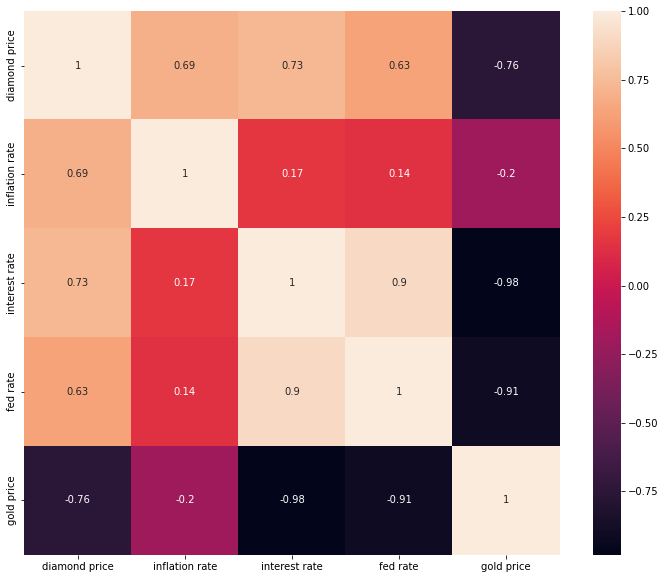

In [5]:
plt.figure(figsize=(12,10))
sns.heatmap(diamond.corr(), annot=True)
plt.savefig('./pic/Correlation Pic/Diamond/Corr_Map.png')

In [9]:
def segment(data,col_name):
    Y = (data[col_name])
    X = data.drop(col_name,axis=1)
    return X,Y

In [10]:
def Train_Valid_Test(data,train_percent,valid_percent,test_percent):
    train_len = int(data.shape[0]*train_percent)
    valid_len = int(data.shape[0]*(train_percent + valid_percent)) 
    train_df = data.iloc[:train_len,:]
    valid_df = data.iloc[train_len:valid_len,:]
    test_df = data.iloc[valid_len:,:]
    return train_df,valid_df,test_df

def Split_Part(data,percent):
    train_len = int(data.shape[0]*percent)
    train_df = data.iloc[:train_len,:]
    test_df = data.iloc[train_len:,:]
    return train_df,test_df

In [11]:
def lag_data(data,max_lag,target):
    X = data.copy()
    X_col = list(X.columns)
    X_col.remove(target)
    for col in X_col:
        for i in range(2,max_lag+1):
            X[col+'_lag_'+str(i)] = X[col].shift(i-1)
    for i in X_col:
        X.rename(columns ={i:i+'_lag_1'},inplace = True)
    X.dropna(inplace = True) 
    return X

### Lag the feature based on the order of feature in data.columns
def lag_feature_df(max_lag,data,target):
    # Store each feature's dataframe:
    X = pd.DataFrame()
    X_col = list(data.columns)
    X_col.remove(target)
    feature_range = range(len(X_col))
    for idx,col in enumerate(X_col):
        for j in range(max_lag):
            X[col+'_lag_'+str(j+1)] = data[col].shift(j)
    X[target] = data[target].copy()
    X.dropna(inplace=True)
    return X

In [12]:
df = diamond.copy()

df['diamond price_1'] = df['diamond price'].shift(-1)
df.dropna(inplace=True)


df_lag = lag_feature_df(30,df,'diamond price_1')

train_lag,valid_lag,test_lag = Train_Valid_Test(df_lag,0.7,0.1,0.2)
## Lagging
X_train_lag,Y_train_lag = segment(train_lag,'diamond price_1')
X_valid_lag,Y_valid_lag = segment(valid_lag,'diamond price_1')
X_test_lag,Y_test_lag = segment(test_lag,'diamond price_1')

train_no,valid_no,test_no = Train_Valid_Test(df.loc[df_lag.index],0.7,0.1,0.2)

## No lagging
X_train_no,Y_train_no = segment(train_no,'diamond price_1')
X_valid_no,Y_valid_no = segment(test_no,'diamond price_1')
X_test_no,Y_test_no = segment(test_no,'diamond price_1')

In [13]:
X_arr = X_train_lag.values

In [14]:
X_train_lag

diamond price_lag_1  diamond price_lag_2  diamond price_lag_3  \
date                                                                        
2018-05-27             10118.63             10112.36             10114.38   
2018-05-28             10111.69             10118.63             10112.36   
2018-05-29             10106.18             10111.69             10118.63   
2018-05-30             10083.90             10106.18             10111.69   
2018-05-31             10083.73             10083.90             10106.18   
...                         ...                  ...                  ...   
2020-07-02              9281.90              9287.89              9296.15   
2020-07-03              9283.35              9281.90              9287.89   
2020-07-04              9276.46              9283.35              9281.90   
2020-07-05              9278.39              9276.46              9283.35   
2020-07-06              9283.84              9278.39              9276.46   

            diamond price_lag_4  diamond price_lag_5  diamond price_lag_6  \
date                                                                        
2018-05-27             10120.91             10108.78             10107.35   
2018-05-28             10114.38             10120.91             10108.78   
2018-05-29             10112.36             10114.38             10120.91   
2018-05-30             10118.63             10112.36             10114.38   
2018-05-31             10111.69             10118.63             10112.36   
...                         ...                  ...                  ...   
2020-07-02              9303.69              9308.30              9307.32   
2020-07-03              9296.15              9303.69              9308.30   
2020-07-04              9287.89              9296.15              9303.69   
2020-07-05              9281.90              9287.89              9296.15   
2020-07-06              9283.35              9281.90              9287.89   

            diamond price_lag_7  diamond price_lag_8  diamond price_lag_9  \
date                                                                        
2018-05-27             10105.50             10105.86             10106.47   
2018-05-28             10107.35             10105.50             10105.86   
2018-05-29             10108.78             10107.35             10105.50   
2018-05-30             10120.91             10108.78             10107.35   
2018-05-31             10114.38             10120.91             10108.78   
...                         ...                  ...                  ...   
2020-07-02              9308.38              9311.19              9319.21   
2020-07-03              9307.32              9308.38              9311.19   
2020-07-04              9308.30              9307.32              9308.38   
2020-07-05              9303.69              9308.30              9307.32   
2020-07-06              9296.15              9303.69              9308.30   

            diamond price_lag_10  ...  gold price_lag_21  gold price_lag_22  \
date                              ...                                         
2018-05-27              10107.98  ...            1316.40            1309.50   
2018-05-28              10106.47  ...            1315.70            1316.40   
2018-05-29              10105.86  ...            1312.63            1315.70   
2018-05-30              10105.50  ...            1321.25            1312.63   
2018-05-31              10107.35  ...            1321.85            1321.25   
...                          ...  ...                ...                ...   
2020-07-02               9327.81  ...            1730.80            1726.30   
2020-07-03               9319.21  ...            1730.80            1730.80   
2020-07-04               9311.19  ...            1730.80            1730.80   
2020-07-05               9308.38  ...            1725.75            1730.80   
2020-07-06               9307.32  ...            1728.57  

In [15]:
X_train_no

diamond price  inflation rate  interest rate  fed rate  gold price
date                                                                          
2018-05-27       10118.63            2.04           0.73      1.70     1301.58
2018-05-28       10111.69            2.04           0.73      1.70     1298.10
2018-05-29       10106.18            2.04           0.73      1.70     1299.00
2018-05-30       10083.90            2.06           0.78      1.70     1309.88
2018-05-31       10083.73            2.07           0.76      1.70     1298.33
...                   ...             ...            ...       ...         ...
2020-07-02        9281.90            1.41          -0.73      0.09     1773.03
2020-07-03        9283.35            1.45          -0.76      0.09     1774.91
2020-07-04        9276.46            1.45          -0.76      0.09     1784.50
2020-07-05        9278.39            1.45          -0.76      0.09     1784.50
2020-07-06        9283.84            1.45          -0.76      0.09     1784.50

[772 rows x 5 columns]

## Prediction Models

In [16]:
def LR_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    reg_Linear =  LinearRegression()
    reg_Linear.fit(x_train,y_train.reshape(-1,))
    y_Linear_a = reg_Linear.predict(x_test)
    y_Linear_a_inverse =minmax_y_test.inverse_transform(y_Linear_a.reshape((-1,1)))
    
    print(
        "Linear:rmse: ",sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
         "Linear:mae:",mean_absolute_error(y_Linear_a_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_Linear_a_inverse,y_test_inverse),
        'mape':mean_absolute_percentage_error(y_Linear_a_inverse,y_test_inverse)
    }
    return error_metrics

In [17]:
def ANN_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    ann_model = keras.Sequential([
        keras.layers.Dense(500,activation='relu',input_shape=[x_train.shape[1]]),
        keras.layers.Dense(500,activation='relu'),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dense(1)])#最后输出为一个结果，也就是预测的值
        #定义损失函数loss，采用的优化器optimizer为Adam
    ann_model.compile(loss='mean_absolute_error',optimizer='Adam')
    
    ann_model.fit(x_train,y_train.reshape(-1,))
    y_ann_model = ann_model.predict(x_test)
    y_ann_model_inverse =minmax_y_test.inverse_transform(y_ann_model.reshape((-1,1)))
    
    print(
          "ANN_mae:%f"%(mean_absolute_error(y_ann_model_inverse, Y_test  ))+"\n",
          "ANN_rmse:%f"%(sqrt(mean_squared_error(y_ann_model_inverse, Y_test  )))+"\n"
     )
    
#     y_df = {
#         "Original": Y_test.values,
#         'RandomForest_':y_ann_model_inverse
#     }
    
    error_metrics = {
        "mae":(mean_absolute_error(y_ann_model_inverse, Y_test  )),
        "rmse":(sqrt(mean_squared_error(y_ann_model_inverse, Y_test  ))),
        'mape':mean_absolute_percentage_error(y_ann_model_inverse, Y_test)
    }
    return error_metrics

In [18]:
def RF_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    rfr = RandomForestRegressor(max_depth=9)
#     param_grid = {"n_estimators":[10,100,300],"max_depth":range(1,31)}
#     grid_search = GridSearchCV(rfr,param_grid,cv = 3)

    rfr.fit(x_train,y_train.reshape(-1,))
    y_rfr = rfr.predict(x_test)
    y_rfr_inverse =minmax_y_test.inverse_transform(y_rfr.reshape((-1,1)))
    
    print(
          "RandomForest_mae:%f"%(mean_absolute_error(y_rfr_inverse, Y_test  ))+"\n",
          "RandomForest_rmse:%f"%(sqrt(mean_squared_error(y_rfr_inverse, Y_test  )))+"\n"
#           "elastic_mse:%f"%(mean_squared_error( y_elastic_inverse, Y_test  )),     
     )
    
#     y_df = {
#         "Original": Y_test.values,
#         'RandomForest_':y_rfr_inverse
#     }
    
    error_metrics = {
        "mae":(mean_absolute_error(y_rfr_inverse, Y_test  )),
        "rmse":(sqrt(mean_squared_error(y_rfr_inverse, Y_test  ))),
        'mape':mean_absolute_percentage_error(y_rfr_inverse, Y_test)
    }
    return error_metrics

In [19]:
def XGB_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))

    xgb = XGBRegressor(max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    objective='reg:squarederror', # 此默认参数与 XGBClassifier 不同
    booster='gbtree',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=0)
    
    
    xgb.fit(x_train,y_train.reshape(-1,),eval_metric='rmse', verbose=50)
    y_xgb = xgb.predict(x_test)
    y_xgb_inverse =minmax_y_test.inverse_transform(y_xgb.reshape((-1,1)))
    
    print(
        "XGB rmse: ",sqrt(mean_squared_error(y_xgb_inverse,Y_test)),
         "XGB mae:",mean_absolute_error(y_xgb_inverse,Y_test)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_xgb_inverse,Y_test)),
        "mae":mean_absolute_error(y_xgb_inverse,Y_test),
        'mape':mean_absolute_percentage_error(y_xgb_inverse,Y_test)
    }
    
    return error_metrics

In [20]:
def LGB_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    gbm = lgb.LGBMRegressor(max_depth=12)
    gbm.fit(x_train, y_train)
    y_gbm = gbm.predict(x_test)
    y_gbm_inverse =minmax_y_test.inverse_transform(y_gbm.reshape((-1,1)))
    
    print(
        "LGB rmse: ",sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
         "LGB mae:",mean_absolute_error(y_gbm_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_gbm_inverse,y_test_inverse),
        'mape':mean_absolute_percentage_error(y_gbm_inverse,y_test_inverse)
    }
    
    
    return error_metrics

In [21]:
def SVR_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
#     parameters = {, 'gamma':np.logspace(-5, 0, num=6, base=2.0),'C':np.logspace(-5, 5, num=11, base=2.0)}
#     grid_search = GridSearchCV(, cv=10, n_jobs=4, scoring='neg_mean_squared_error')
    svr = SVR(kernel='rbf', C=1e3, gamma=0.01)
    svr.fit(x_train,y_train.reshape(-1,))
#     print(grid_search.best_params_)
    y_svr = svr.predict(x_test)
    
    y_svr_inverse = minmax_y_test.inverse_transform(y_svr.reshape((-1,1)))
    
    print(
        "SVR rmse: ",sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
         "SVR mae:",mean_absolute_error(y_svr_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_svr_inverse,y_test_inverse),
        'mape':mean_absolute_percentage_error(y_svr_inverse,y_test_inverse)
    }
    
    return error_metrics

## BenchMark

In [22]:
def stacking_models(X_train,Y_train,X_test,Y_test):
    model_df =pd.DataFrame({
                 LR_Model.__name__:LR_Model(X_train,Y_train,X_test,Y_test),
                 RF_Model.__name__:RF_Model(X_train,Y_train,X_test,Y_test),
                 ANN_Model.__name__:ANN_Model(X_train,Y_train,X_test,Y_test),
                 XGB_Model.__name__:XGB_Model(X_train,Y_train,X_test,Y_test),
                 LGB_Model.__name__:LGB_Model(X_train,Y_train,X_test,Y_test),
                 SVR_Model.__name__:SVR_Model(X_train,Y_train,X_test,Y_test),
                }
                )
    return model_df

In [23]:
mi_xy = mutual_info_regression(X_train_lag,Y_train_lag)
mi_xx = np.zeros([X_train_lag.shape[1],X_train_lag.shape[1]])

for i in range(mi_xx.shape[1]):
    for j in range(mi_xx.shape[1]):
        mi_xx[i][j] = mutual_info_regression(X_arr[:,i].reshape(-1,1),X_arr[:,j])
    print(i+1,'/',mi_xx.shape[1],end='\r',flush=True)

In [ ]:
def mRMR(selected,idx,metric_xy,metric_xx):
    
    mrmr = 0.0
    
    if len(selected) == 0:
        mrmr = metric_xy[idx]
        
    else:
        relevance_score = 0
        redundency_score = 0
        relevance_score = metric_xy[idx] 
        X_s = selected+[idx]
        col_len = len(selected)
        
        for i in selected:
            redundency_score+=metric_xx[idx][i]
        redundency_score/=(col_len)
        
#         for i in X_s:
#             relevance_score+=metric_xy[i]
#         relevance_score/=(col_len)
        

#         for i in range(col_len - 1):
#             for j in range(i+1,col_len):
#                 redundency_score+=metric_xx[X_s[i]][X_s[j]]
#         redundency_score/=(col_len)
        
        mrmr = (relevance_score - redundency_score)

    return mrmr

def incremental_selection(x,metric):
    X = np.array(x)
    selected = [] # indices of selected fetures
    rest = list(range(X.shape[1]))
    scores = []
    metric_xy = []
    metric_xx = []
    # stop = False
    if metric == 'MI-MI':
        metric_xy = mi_xy
        metric_xx = mi_xx
    elif metric == 'MI-MI-Norm':
        metric_xy = mi_xy_norm 
        metric_xx = mi_norm
    elif metric == 'MI-MIC':
        metric_xy = mi_xy_norm
        metric_xx = mic_norm
    elif metric == 'MIC-MI':
        metric_xy = mic_xy_norm
        metric_xx = mi_norm
    elif metric =='MI-CCF':
        metric_xy = mi_xy
        metric_xx = ccf_xx
    elif metric=='MI-CCF-Norm':
        metric_xy = mi_xy_norm
        metric_xx = ccf_norm
    elif metric == 'MI-Pearson':
        metric_xy = mi_xy_norm
        metric_xx = pearson_norm   
    print(metric)
    while len(rest)>0 :
        id_max = rest[0]
        max_score = 0   
        for idx in rest:
            temp_score = mRMR(selected,idx,metric_xy,metric_xx)
            if temp_score>max_score:
                id_max = idx
                max_score = temp_score
        if max_score <=0:        
             return selected
             break                
        selected = selected + [id_max]
        rest.remove(id_max)
        print(f"selected:{selected},delta_score:{max_score}",end = "\r",flush=True)
    
    return selected

In [ ]:
mi_mi = incremental_selection(X_train_lag,'MI-MI')
len(mi_mi)

In [ ]:
MI_MI_result = stacking_models(X_train_lag.iloc[:,mi_mi],Y_train_lag,X_test_lag.iloc[:,mi_mi],Y_test_lag)

### Raw Data

In [17]:
raw_df = stacking_models(X_train_no,Y_train_no,X_test_no,Y_test_no)

Linear:rmse:  7.236201376018461 Linear:mae: 5.99760670803053
RandomForest_mae:13.327421
 RandomForest_rmse:18.031264

25/25 [==============================] - 1s 4ms/step - loss: 0.1329
ANN_mae:106.387258
 ANN_rmse:142.725491

XGB rmse:  30.481348917772298 XGB mae: 20.401365773472833
LGB rmse:  20.493685242883778 LGB mae: 15.935807361370705
SVR rmse:  75.46058148153537 SVR mae: 53.85546336016151


In [18]:
raw_df

LR_Model   RF_Model   ANN_Model  XGB_Model  LGB_Model  SVR_Model
rmse  7.236201  18.031264  142.725491  30.481349  20.493685  75.460581
mae   5.997607  13.327421  106.387258  20.401366  15.935807  53.855463
mape  0.000600   0.001341    0.010674   0.002016   0.001596   0.005364

### All Lag

In [22]:
all_df = stacking_models(X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

Linear:rmse:  13.532464553062663 Linear:mae: 11.247973905489419
RandomForest_mae:53.795875
 RandomForest_rmse:72.885542

25/25 [==============================] - 0s 4ms/step - loss: 0.1287
ANN_mae:90.334674
 ANN_rmse:108.762124

XGB rmse:  71.51784337936547 XGB mae: 40.086000777714986
LGB rmse:  45.57628744940954 LGB mae: 33.58342333744376
SVR rmse:  80.06227740347917 SVR mae: 68.18267170023597


In [23]:
all_df

LR_Model   RF_Model   ANN_Model  XGB_Model  LGB_Model  SVR_Model
rmse  13.532465  72.885542  108.762124  71.517843  45.576287  80.062277
mae   11.247974  53.795875   90.334674  40.086001  33.583423  68.182672
mape   0.001127   0.005376    0.009038   0.003972   0.003341   0.006805

## PACF

In [24]:
def lag_based_PACF(data,max_lag,width):
    lags_pacf,interval = stattools.pacf(data,max_lag,"yw",width)
    lags = []
    boundary = (interval[:,1] - lags_pacf)[1]
    lags_pacf = np.abs(lags_pacf)
    for idx,lag in enumerate(lags_pacf):
        if lag > boundary:
            lags.append(idx)
    return lags

In [25]:
lags_pacf = {}
for col in X_train_no.columns:
    lags_pacf[col] = lag_based_PACF(X_train_no[col],29,0.05)
cols = []
for k,v in lags_pacf.items():
    for j in v:
        cols.append(k+'_lag_'+str(j+1))        

In [26]:
len(cols)

28

In [27]:
pacf_df = stacking_models(X_train_lag[cols],Y_train_lag,X_test_lag[cols],Y_test_lag)

Linear:rmse:  10.445008560673903 Linear:mae: 9.000349600849779
RandomForest_mae:30.097715
 RandomForest_rmse:36.368066

25/25 [==============================] - 0s 4ms/step - loss: 0.1267
ANN_mae:92.457767
 ANN_rmse:127.192135

XGB rmse:  45.5031353362004 XGB mae: 27.931542350113112
LGB rmse:  29.98181565474789 LGB mae: 24.50273840073507
SVR rmse:  98.97223915088942 SVR mae: 72.60296292683012


In [28]:
pacf_df

LR_Model   RF_Model   ANN_Model  XGB_Model  LGB_Model  SVR_Model
rmse  10.445009  36.368066  127.192135  45.503135  29.981816  98.972239
mae    9.000350  30.097715   92.457767  27.931542  24.502738  72.602963
mape   0.000904   0.003009    0.009272   0.002758   0.002459   0.007249

In [29]:
X_train_no.shape[1]

5

## Feature Selection

### Construct Corr Matrix 

In [30]:
x_mat = np.zeros([X_train_lag.shape[1],X_train_lag.shape[1]])
feature_num = X_train_no.shape[1]
max_lag = 30

for i in range(0,feature_num):
    ## For each feature,we computew its corr with its self and other features
    ## Self Correlation
    row_start = max_lag*i
    col_end = max_lag*(i+1)
    print(row_start,col_end)
    x_mat[row_start,row_start+1:col_end] = [stats.pearsonr(X_arr[:,row_start],X_arr[:,p])[0] for p in range(max_lag*i+1,max_lag*(i+1))]
    ## Diagnal
    for k in range(row_start+1,col_end-1):
        for j in range(row_start,max_lag*(i+1)-(k-max_lag*i)):
            x_mat[j,j+(k-max_lag*i)] = x_mat[row_start,k]
            
    ## Between Features
    for row in range(col_end,X_arr.shape[1]):
        for col in range(row_start,col_end):
            x_mat[col][row] = stats.pearsonr(X_arr[:,row],X_arr[:,col])[0]

0 30
30 60
60 90
90 120
120 150


In [31]:
corr_copy = np.abs(copy.deepcopy(x_mat))

In [32]:
pd.DataFrame(corr_copy)

0         1         2         3         4         5         6    \
0    0.0  0.998907  0.997601  0.996299  0.995026  0.993717  0.992310   
1    0.0  0.000000  0.998907  0.997601  0.996299  0.995026  0.993717   
2    0.0  0.000000  0.000000  0.998907  0.997601  0.996299  0.995026   
3    0.0  0.000000  0.000000  0.000000  0.998907  0.997601  0.996299   
4    0.0  0.000000  0.000000  0.000000  0.000000  0.998907  0.997601   
..   ...       ...       ...       ...       ...       ...       ...   
145  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
146  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
147  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
148  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
149  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9    ...       140       141       142  \
0    0.990883  0.989445  0.987956  ...  0.949996  0.948897  0.947779   
1    0.992310  0.990883  0.989445  ...  0.950622  0.949569  0.948466   
2    0.993717  0.992310  0.990883  ...  0.951212  0.950195  0.949138   
3    0.995026  0.993717  0.992310  ...  0.951687  0.950794  0.949774   
4    0.996299  0.995026  0.993717  ...  0.951903  0.951251  0.950356   
..        ...       ...       ...  ...       ...       ...       ...   
145  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
146  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
147  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
148  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
149  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

          143       144       145       146       147       148       149  
0    0.946773  0.945689  0.944522  0.943364  0.942283  0.941073  0.939820  
1    0.947363  0.946343  0.945214  0.944035  0.942934  0.941875  0.940674  
2    0.948050  0.946932  0.945867  0.944727  0.943603  0.942528  0.941480  
3    0.948731  0.947628  0.946465  0.945390  0.944302  0.943204  0.942142  
4    0.949352  0.948294  0.947143  0.945969  0.944952  0.943891  0.942805  
..        ...       ...       ...       ...       ...       ...       ...  
145  0.000000  0.000000  0.000000  0.995315  0.991727  0.989649  0.986954  
146  0.000000  0.000000  0.000000  0.000000  0.995315  0.991727  0.989649  
147  0.000000  0.000000  0.000000  0.000000  0.000000  0.995315  0.991727  
148  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.995315  
149  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[150 rows x 150 columns]

In [33]:
def flat(nums):
    res = []
    for i in nums:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

In [34]:
def generate_feature_subsets(corr_matrix,threshold,X_train,Y_train):
    
    correlation_pairs = np.argwhere(corr_matrix>=threshold)
    
    # Check how many features are highly correlated with 1 feature
    correlated_pairs_dict = {}

    for i in set(correlation_pairs[:,0]):
        correlated_pairs_dict[i] = []
        for j in correlation_pairs:
            if j[0]==i:
                correlated_pairs_dict[i].append(j[1])
                
    high_correlated_features = list(set(correlation_pairs.flatten()))
    print("High_correlated_features",len(high_correlated_features))
    corr_cols = X_train.columns[high_correlated_features]
    
    check_corr_pairs = {}
    kk = list(correlated_pairs_dict.keys())
    kk_copy = kk.copy()
    for j in kk_copy:
        check_corr_pairs[j] = correlated_pairs_dict[j].copy()
        for i in correlated_pairs_dict[j]:
            if i in kk:
                check_corr_pairs[j].append(correlated_pairs_dict[i])
                for q in correlated_pairs_dict[i]:
                    if q in kk_copy:
                        kk_copy.remove(q)
            if i in kk_copy:
                    kk_copy.remove(i)
        check_corr_pairs[j] = list(set(flat(check_corr_pairs[j])))
        
    ### Make redundant features into groups    
    redundant_group = []

    for k,v in check_corr_pairs.items():
        redundant_group.append([k]+v)
    
    # Rank features according to MI
    max_feats = len(corr_cols)
    sel_function = mutual_info_regression
    fs = SelectKBest(score_func=sel_function, k=max_feats)
    fs.fit(X_train[corr_cols],Y_train)
    mutual_info = dict(zip(high_correlated_features,fs.scores_))
    sorted_by_mutual_info =[key for (key,val) in sorted(mutual_info.items(), key=lambda kv: kv[1],reverse=True)]
#     print("sorted_by_mutual_info",sorted_by_mutual_info)
    
    ## Highly-Correlated Features
    mrmr_features = []
    for i in redundant_group:
        indexes = [sorted_by_mutual_info.index(j) for j in i]
        mrmr_features.append(sorted_by_mutual_info[min(indexes)])
    print("MRMR Features",len(mrmr_features))

    ## Uncorelated features
    lst = []
    for i in range(X_train.shape[1]):
        if i not in high_correlated_features:
            lst.append(i)
    ## Joint filtered features with uncorrelated pairs
    final_list = list(set(mrmr_features+lst))
    
    print("Final Features:",len(final_list))
    return final_list,len(mrmr_features),len(high_correlated_features)

In [38]:
feature_collections = {}
mrmr_len = {}
correlated_features_len = {}
for i in np.round(arange(0.95,0.99,0.005),3):
    print(i)
    results = generate_feature_subsets(corr_copy,i,X_train_lag,Y_train_lag)
    feature_collections[i] = list(X_train_lag.columns[results[0]])
    mrmr_len[i] = results[1]
    correlated_features_len[i] = results[2]

0.95
High_correlated_features 150
MRMR Features 5
Final Features: 5
0.955
High_correlated_features 150
MRMR Features 5
Final Features: 5
0.96
High_correlated_features 150
MRMR Features 5
Final Features: 5
0.965
High_correlated_features 150
MRMR Features 8
Final Features: 8
0.97
High_correlated_features 150
MRMR Features 8
Final Features: 8
0.975
High_correlated_features 150
MRMR Features 11
Final Features: 11
0.98
High_correlated_features 150
MRMR Features 12
Final Features: 12
0.985
High_correlated_features 150
MRMR Features 17
Final Features: 17
0.99
High_correlated_features 150
MRMR Features 23
Final Features: 23


In [39]:
for k,v in feature_collections.items():
    print(k,len(v))

0.95 5
0.955 5
0.96 5
0.965 8
0.97 8
0.975 11
0.98 12
0.985 17
0.99 23


In [40]:
feature_nums = {}
for k,v in feature_collections.items():
    feature_nums[k] = len(v)

In [41]:
features_compare = pd.DataFrame({
                "High correlated Features":correlated_features_len,
                "MRMR":mrmr_len,
                'Final Features':feature_nums
})

In [42]:
features_compare

High correlated Features  MRMR  Final Features
0.950                       150     5               5
0.955                       150     5               5
0.960                       150     5               5
0.965                       150     8               8
0.970                       150     8               8
0.975                       150    11              11
0.980                       150    12              12
0.985                       150    17              17
0.990                       150    23              23

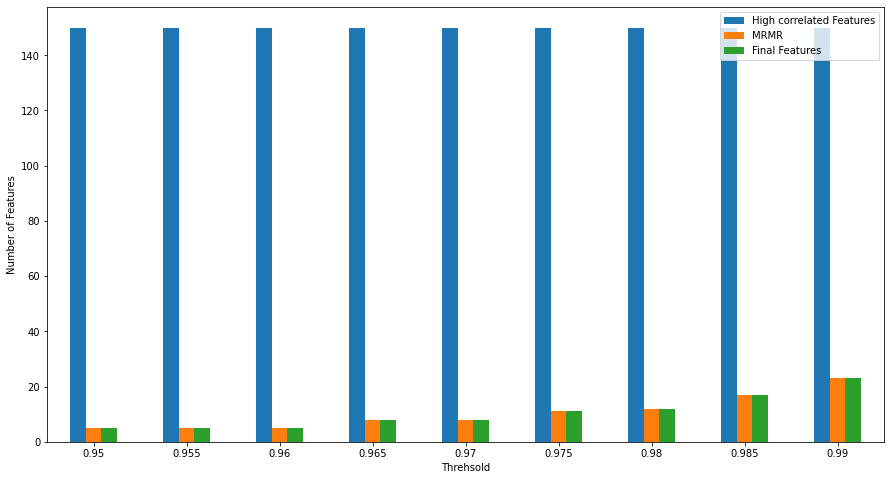

In [45]:
# plt.figure()
ax = features_compare.plot.bar(rot=0,figsize=(15,8))
plt.legend(loc='upper right')
plt.xlabel("Threhsold")
plt.ylabel("Number of Features")
plt.savefig("./pic/Correlation Pic/Diamond/feature_reduction_Diamond.png")

## Recursive Feature Elimination

## LightBGM,Random Forest,XGBoost

In [46]:
def lgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    gbm = lgb.LGBMRegressor()
    gbm.fit(x_train, y_train,eval_set = [(x_test,y_test)],early_stopping_rounds = 10)

    features = X_train.columns
    importances = gbm.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = features
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
    
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with LightBGM model')
#     plt.show()
    
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [47]:
def rfr_pipeline(X_train,Y_train,top_feature_num,i):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))

    rfr = RandomForestRegressor()
    rfr.fit(x_train,y_train.reshape(-1,))
    
    feature_names = X_train.columns
    importances = rfr.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
    
#     fig = sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with Random Forest model')
#     plt.savefig('./pic/RMSE/Electricity/feature_round_'+str(i)+'.png')
#     plt.show()
    
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    
    return top_features

In [48]:
def xgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    xgb = XGBRegressor()
    xgb.fit(x_train,y_train.reshape(-1,),eval_set=[(x_test, y_test)],early_stopping_rounds=10)

    feature_names = X_train.columns
    importances = xgb.feature_importances_
#     plot_importance(xgb,max_num_features=10,importance_type='gain',show_values=False)
    
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
# #     plt.barh(importances_df['Feature_Name'][:10], importances_df['Feature_Importance'][:10]) 
#     plt.title('Top 10 features with XGB model')
#     plt.show()
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [49]:
def rfr_recursive(cols,feature_num_1,feature_num_2,X_train,Y_train,):
    
    max_end = int(0.2*len(cols))
    
    range_end = 0
    
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                rfr_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    rfr_features.append( rfr_pipeline(X_train[now_cols],Y_train,j,i))
                rfr_features = list(set(np.array(rfr_features).flatten()))
                features_dict[j] = rfr_features
                print(j,end='\r',flush=True)
                
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
        features_dict = {}
        for j in range(feature_num_1,range_end+1):
            rfr_features = []
            for i in range(5):
                col_len = int(len(cols)*i*0.2)
                now_cols = cols[col_len:]
                rfr_features.append( rfr_pipeline(X_train[now_cols],Y_train,j,i))

            rfr_features = list(set(np.array(rfr_features).flatten()))
            features_dict[j] = rfr_features
        
            print(j,end='\r',flush=True)
        return features_dict

In [50]:
def lgb_recursive(cols,feature_num_1,feature_num_2,X_train,Y_train,X_valid,Y_valid):
    
    max_end = int(0.2*len(cols))
    range_end = 0

    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                lgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    lgb_features.append( lgb_pipeline(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))

                lgb_features = list(set(np.array(lgb_features).flatten()))
                features_dict[j] = lgb_features
                print(j,end='\r',flush=True)
            return features_dict
        
    features_dict = {}
    
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
    
    for j in range(feature_num_1,range_end+1):
        lgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            lgb_features.append(lgb_pipeline(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
        lgb_features = list(set(np.array(lgb_features).flatten()))
        features_dict[j] = lgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [51]:
def xgb_recursive(cols,feature_num_1,feature_num_2,X_train,Y_train,X_valid,Y_valid):
    
    max_end = int(0.2*len(cols))
    range_end = 0
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                xgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    xgb_features.append( xgb_pipeline(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
                xgb_features = list(set(np.array(xgb_features).flatten()))
                features_dict[j] = xgb_features
                print(j,end='\r',flush=True)
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
    features_dict = {}
    for j in range(feature_num_1,range_end +1):
        xgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            xgb_features.append( xgb_pipeline(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
        xgb_features = list(set(np.array(xgb_features).flatten()))
        features_dict[j] = xgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [52]:
real_lgb = {}
for k,v in feature_collections.items():
    real_lgb[k] = lgb_recursive(v,1,5,X_train_lag,Y_train_lag,X_valid_lag,Y_valid_lag)

[1]	valid_0's l2: 0.109365
[2]	valid_0's l2: 0.0888944
[3]	valid_0's l2: 0.0720806
[4]	valid_0's l2: 0.0584888
[5]	valid_0's l2: 0.0500657
[6]	valid_0's l2: 0.0409708
[7]	valid_0's l2: 0.0334953
[8]	valid_0's l2: 0.0327048
[9]	valid_0's l2: 0.0273667
[10]	valid_0's l2: 0.0230356
[11]	valid_0's l2: 0.0194032
[12]	valid_0's l2: 0.0191383
[13]	valid_0's l2: 0.016428
[14]	valid_0's l2: 0.0146819
[15]	valid_0's l2: 0.0145823
[16]	valid_0's l2: 0.0132597
[17]	valid_0's l2: 0.0118583
[18]	valid_0's l2: 0.0106871
[19]	valid_0's l2: 0.00965167
[20]	valid_0's l2: 0.0096343
[21]	valid_0's l2: 0.00881871
[22]	valid_0's l2: 0.00815395
[23]	valid_0's l2: 0.00759458
[24]	valid_0's l2: 0.0070758
[25]	valid_0's l2: 0.00675745
[26]	valid_0's l2: 0.00638577
[27]	valid_0's l2: 0.00607398
[28]	valid_0's l2: 0.00589592
[29]	valid_0's l2: 0.00570531
[30]	valid_0's l2: 0.00548663
[31]	valid_0's l2: 0.0052724
[32]	valid_0's l2: 0.00533722
[33]	valid_0's l2: 0.00526097
[34]	valid_0's l2: 0.00519682
[35]	valid_0

[60]	valid_0's l2: 0.006227
[61]	valid_0's l2: 0.00620353
[62]	valid_0's l2: 0.00620636
[63]	valid_0's l2: 0.00620535
[64]	valid_0's l2: 0.00617776
[65]	valid_0's l2: 0.00617423
[66]	valid_0's l2: 0.00618331
[67]	valid_0's l2: 0.00618362
[68]	valid_0's l2: 0.00618349
[69]	valid_0's l2: 0.00618692
[70]	valid_0's l2: 0.0061895
[71]	valid_0's l2: 0.00619313
[72]	valid_0's l2: 0.00616694
[73]	valid_0's l2: 0.00616847
[74]	valid_0's l2: 0.00614297
[75]	valid_0's l2: 0.006135
[76]	valid_0's l2: 0.0061377
[77]	valid_0's l2: 0.00614362
[78]	valid_0's l2: 0.00612378
[79]	valid_0's l2: 0.00612721
[80]	valid_0's l2: 0.00612706
[81]	valid_0's l2: 0.00618446
[82]	valid_0's l2: 0.00618386
[83]	valid_0's l2: 0.00620291
[84]	valid_0's l2: 0.00618316
[85]	valid_0's l2: 0.00623271
[86]	valid_0's l2: 0.0062107
[87]	valid_0's l2: 0.00620996
[88]	valid_0's l2: 0.00620569
[1]	valid_0's l2: 0.140207
[2]	valid_0's l2: 0.144788
[3]	valid_0's l2: 0.150107
[4]	valid_0's l2: 0.152284
[5]	valid_0's l2: 0.155386
[6

[6]	valid_0's l2: 0.123073
[7]	valid_0's l2: 0.123296
[8]	valid_0's l2: 0.124633
[9]	valid_0's l2: 0.125911
[10]	valid_0's l2: 0.127075
[11]	valid_0's l2: 0.12805
[12]	valid_0's l2: 0.129142
[13]	valid_0's l2: 0.13026
[14]	valid_0's l2: 0.131326
[15]	valid_0's l2: 0.132288
[1]	valid_0's l2: 0.128345
[2]	valid_0's l2: 0.123732
[3]	valid_0's l2: 0.122631
[4]	valid_0's l2: 0.119808
[5]	valid_0's l2: 0.119075
[6]	valid_0's l2: 0.119725
[7]	valid_0's l2: 0.12122
[8]	valid_0's l2: 0.122741
[9]	valid_0's l2: 0.125735
[10]	valid_0's l2: 0.128133
[11]	valid_0's l2: 0.12986
[12]	valid_0's l2: 0.132664
[13]	valid_0's l2: 0.134116
[14]	valid_0's l2: 0.136406
[15]	valid_0's l2: 0.138035
[1]	valid_0's l2: 0.113451
[2]	valid_0's l2: 0.0957866
[3]	valid_0's l2: 0.0812516
[4]	valid_0's l2: 0.0667887
[5]	valid_0's l2: 0.0577924
[6]	valid_0's l2: 0.0480018
[7]	valid_0's l2: 0.0412299
[8]	valid_0's l2: 0.0344896
[9]	valid_0's l2: 0.0291351
[10]	valid_0's l2: 0.0245412
[11]	valid_0's l2: 0.0239184
[12]	val

[1]	valid_0's l2: 0.133195
[2]	valid_0's l2: 0.132261
[3]	valid_0's l2: 0.132557
[4]	valid_0's l2: 0.133603
[5]	valid_0's l2: 0.134833
[6]	valid_0's l2: 0.135595
[7]	valid_0's l2: 0.136473
[8]	valid_0's l2: 0.137491
[9]	valid_0's l2: 0.139189
[10]	valid_0's l2: 0.132626
[11]	valid_0's l2: 0.127017
[12]	valid_0's l2: 0.121838
[13]	valid_0's l2: 0.117563
[14]	valid_0's l2: 0.114019
[15]	valid_0's l2: 0.111097
[16]	valid_0's l2: 0.108381
[17]	valid_0's l2: 0.106222
[18]	valid_0's l2: 0.104423
[19]	valid_0's l2: 0.10352
[20]	valid_0's l2: 0.101839
[21]	valid_0's l2: 0.101185
[22]	valid_0's l2: 0.100483
[23]	valid_0's l2: 0.0991797
[24]	valid_0's l2: 0.0988747
[25]	valid_0's l2: 0.0977778
[26]	valid_0's l2: 0.0972243
[27]	valid_0's l2: 0.0966781
[28]	valid_0's l2: 0.0963679
[29]	valid_0's l2: 0.0958719
[30]	valid_0's l2: 0.0957325
[31]	valid_0's l2: 0.0952277
[32]	valid_0's l2: 0.0951554
[33]	valid_0's l2: 0.0948462
[34]	valid_0's l2: 0.0944829
[35]	valid_0's l2: 0.0941382
[36]	valid_0's l2

[75]	valid_0's l2: 0.0919936
[76]	valid_0's l2: 0.0920084
[77]	valid_0's l2: 0.0919932
[78]	valid_0's l2: 0.0920266
[79]	valid_0's l2: 0.0920309
[80]	valid_0's l2: 0.0920236
[1]	valid_0's l2: 0.133195
[2]	valid_0's l2: 0.132261
[3]	valid_0's l2: 0.132557
[4]	valid_0's l2: 0.133603
[5]	valid_0's l2: 0.134833
[6]	valid_0's l2: 0.135595
[7]	valid_0's l2: 0.136473
[8]	valid_0's l2: 0.137491
[9]	valid_0's l2: 0.139189
[10]	valid_0's l2: 0.132626
[11]	valid_0's l2: 0.127017
[12]	valid_0's l2: 0.121838
[13]	valid_0's l2: 0.117563
[14]	valid_0's l2: 0.114019
[15]	valid_0's l2: 0.111097
[16]	valid_0's l2: 0.108381
[17]	valid_0's l2: 0.106222
[18]	valid_0's l2: 0.104423
[19]	valid_0's l2: 0.10352
[20]	valid_0's l2: 0.101839
[21]	valid_0's l2: 0.101185
[22]	valid_0's l2: 0.100483
[23]	valid_0's l2: 0.0991797
[24]	valid_0's l2: 0.0988747
[25]	valid_0's l2: 0.0977778
[26]	valid_0's l2: 0.0972243
[27]	valid_0's l2: 0.0966781
[28]	valid_0's l2: 0.0963679
[29]	valid_0's l2: 0.0958719
[30]	valid_0's l2

[2]	valid_0's l2: 0.132261
[3]	valid_0's l2: 0.132557
[4]	valid_0's l2: 0.133603
[5]	valid_0's l2: 0.134833
[6]	valid_0's l2: 0.135595
[7]	valid_0's l2: 0.136473
[8]	valid_0's l2: 0.137491
[9]	valid_0's l2: 0.139189
[10]	valid_0's l2: 0.132626
[11]	valid_0's l2: 0.127017
[12]	valid_0's l2: 0.121838
[13]	valid_0's l2: 0.117563
[14]	valid_0's l2: 0.114019
[15]	valid_0's l2: 0.111097
[16]	valid_0's l2: 0.108381
[17]	valid_0's l2: 0.106222
[18]	valid_0's l2: 0.104423
[19]	valid_0's l2: 0.10352
[20]	valid_0's l2: 0.101839
[21]	valid_0's l2: 0.101185
[22]	valid_0's l2: 0.100483
[23]	valid_0's l2: 0.0991797
[24]	valid_0's l2: 0.0988747
[25]	valid_0's l2: 0.0977778
[26]	valid_0's l2: 0.0972243
[27]	valid_0's l2: 0.0966781
[28]	valid_0's l2: 0.0963679
[29]	valid_0's l2: 0.0958719
[30]	valid_0's l2: 0.0957325
[31]	valid_0's l2: 0.0952277
[32]	valid_0's l2: 0.0951554
[33]	valid_0's l2: 0.0948462
[34]	valid_0's l2: 0.0944829
[35]	valid_0's l2: 0.0941382
[36]	valid_0's l2: 0.09405
[37]	valid_0's l2

[1]	valid_0's l2: 0.113602
[2]	valid_0's l2: 0.09628
[3]	valid_0's l2: 0.0967375
[4]	valid_0's l2: 0.0835349
[5]	valid_0's l2: 0.0726059
[6]	valid_0's l2: 0.0625217
[7]	valid_0's l2: 0.053102
[8]	valid_0's l2: 0.0475675
[9]	valid_0's l2: 0.0411052
[10]	valid_0's l2: 0.0356243
[11]	valid_0's l2: 0.0313551
[12]	valid_0's l2: 0.0315009
[13]	valid_0's l2: 0.0288533
[14]	valid_0's l2: 0.0267364
[15]	valid_0's l2: 0.0243071
[16]	valid_0's l2: 0.0222927
[17]	valid_0's l2: 0.0205057
[18]	valid_0's l2: 0.0190044
[19]	valid_0's l2: 0.0177091
[20]	valid_0's l2: 0.0167024
[21]	valid_0's l2: 0.0156933
[22]	valid_0's l2: 0.0148402
[23]	valid_0's l2: 0.0142109
[24]	valid_0's l2: 0.0135723
[25]	valid_0's l2: 0.0129928
[26]	valid_0's l2: 0.0125022
[27]	valid_0's l2: 0.012202
[28]	valid_0's l2: 0.0118282
[29]	valid_0's l2: 0.0115497
[30]	valid_0's l2: 0.0112639
[31]	valid_0's l2: 0.0110254
[32]	valid_0's l2: 0.0109419
[33]	valid_0's l2: 0.0107862
[34]	valid_0's l2: 0.0107029
[35]	valid_0's l2: 0.0106099

In [53]:
real_xgb = {}   
for k,v in feature_collections.items():
    print(k)
    real_xgb[k] = xgb_recursive(v,1,5,X_train_lag,Y_train_lag,X_valid_lag,Y_valid_lag)

0.95
0.955
0.96
0.965
[0]	validation_0-rmse:0.24937
[1]	validation_0-rmse:0.17926
[2]	validation_0-rmse:0.17835
[3]	validation_0-rmse:0.14426
[4]	validation_0-rmse:0.12015
[5]	validation_0-rmse:0.10217
[6]	validation_0-rmse:0.10679
[7]	validation_0-rmse:0.09898
[8]	validation_0-rmse:0.09542
[9]	validation_0-rmse:0.09581
[10]	validation_0-rmse:0.10067
[11]	validation_0-rmse:0.10136
[12]	validation_0-rmse:0.10060
[13]	validation_0-rmse:0.10096
[14]	validation_0-rmse:0.10096
[15]	validation_0-rmse:0.10146
[16]	validation_0-rmse:0.10153
[17]	validation_0-rmse:0.10156
[18]	validation_0-rmse:0.10149
[0]	validation_0-rmse:0.38783
[1]	validation_0-rmse:0.41471
[2]	validation_0-rmse:0.42627
[3]	validation_0-rmse:0.44083
[4]	validation_0-rmse:0.44736
[5]	validation_0-rmse:0.45533
[6]	validation_0-rmse:0.45817
[7]	validation_0-rmse:0.45984
[8]	validation_0-rmse:0.46150
[9]	validation_0-rmse:0.46271
[10]	validation_0-rmse:0.46336
[0]	validation_0-rmse:0.38285
[1]	validation_0-rmse:0.41090
[2]	vali

[5]	validation_0-rmse:0.05367
[6]	validation_0-rmse:0.04123
[7]	validation_0-rmse:0.03311
[8]	validation_0-rmse:0.03360
[9]	validation_0-rmse:0.03147
[10]	validation_0-rmse:0.03529
[11]	validation_0-rmse:0.03571
[12]	validation_0-rmse:0.03601
[13]	validation_0-rmse:0.03604
[14]	validation_0-rmse:0.03617
[15]	validation_0-rmse:0.03585
[16]	validation_0-rmse:0.03608
[17]	validation_0-rmse:0.03604
[18]	validation_0-rmse:0.03615
[0]	validation_0-rmse:0.37900
[1]	validation_0-rmse:0.39403
[2]	validation_0-rmse:0.40555
[3]	validation_0-rmse:0.41630
[4]	validation_0-rmse:0.42247
[5]	validation_0-rmse:0.42692
[6]	validation_0-rmse:0.43048
[7]	validation_0-rmse:0.43293
[8]	validation_0-rmse:0.43514
[9]	validation_0-rmse:0.43610
[0]	validation_0-rmse:0.37210
[1]	validation_0-rmse:0.38616
[2]	validation_0-rmse:0.39447
[3]	validation_0-rmse:0.41835
[4]	validation_0-rmse:0.42715
[5]	validation_0-rmse:0.43186
[6]	validation_0-rmse:0.43681
[7]	validation_0-rmse:0.43947
[8]	validation_0-rmse:0.44092
[

[5]	validation_0-rmse:0.38114
[6]	validation_0-rmse:0.38700
[7]	validation_0-rmse:0.38997
[8]	validation_0-rmse:0.39226
[9]	validation_0-rmse:0.39443
[0]	validation_0-rmse:0.34923
[1]	validation_0-rmse:0.35567
[2]	validation_0-rmse:0.36351
[3]	validation_0-rmse:0.36917
[4]	validation_0-rmse:0.37488
[5]	validation_0-rmse:0.37913
[6]	validation_0-rmse:0.38157
[7]	validation_0-rmse:0.38416
[8]	validation_0-rmse:0.38735
[9]	validation_0-rmse:0.38893
[10]	validation_0-rmse:0.39009
0.99
[0]	validation_0-rmse:0.24983
[1]	validation_0-rmse:0.17991
[2]	validation_0-rmse:0.13567
[3]	validation_0-rmse:0.10169
[4]	validation_0-rmse:0.08032
[5]	validation_0-rmse:0.06478
[6]	validation_0-rmse:0.05724
[7]	validation_0-rmse:0.05903
[8]	validation_0-rmse:0.05605
[9]	validation_0-rmse:0.06067
[10]	validation_0-rmse:0.06210
[11]	validation_0-rmse:0.06242
[12]	validation_0-rmse:0.06341
[13]	validation_0-rmse:0.06634
[14]	validation_0-rmse:0.06654
[15]	validation_0-rmse:0.06748
[16]	validation_0-rmse:0.067

In [54]:
real_rfr = {}
for k,v in feature_collections.items():
    %time real_rfr[k] = rfr_recursive(v,1,5,X_train_lag,Y_train_lag)

Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 1.81 s
Wall time: 2.15 s
Wall time: 4.52 s
Wall time: 3.57 s
Wall time: 5.56 s
Wall time: 9.23 s


## Delete null features under some threshold

In [55]:
for k in list(real_lgb.keys()):
    if len(real_lgb[k])==0:
        del real_lgb[k]
for k in list(real_xgb.keys()):
    if len(real_xgb[k])==0:
        del real_xgb[k]
for k in list(real_rfr.keys()):
    if real_rfr[k]==None or len(real_rfr)==0:
        del real_rfr[k]

In [60]:
np.save('real_lgb.npy', real_lgb)

In [61]:
np.save('real_xgb.npy', real_xgb)

In [62]:
np.save('real_rfr.npy', real_rfr)

### Mix Models

In [56]:
import random

In [59]:
def mix_recursive(cols,feature_num_1,feature_num_2,X_train,Y_train,X_valid,Y_valid):
    
    max_end = int(0.2*len(cols))
    range_end = 0
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                mix_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    if i<3:
                        model = xgb_pipeline
                    else:
                        model = lgb_pipeline
                    mix_features.append( model(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
                mix_features = list(set(np.array(mix_features).flatten()))
                features_dict[j] = mix_features
                print(j,end='\r',flush=True)
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
    features_dict = {}
    for j in range(feature_num_1,range_end +1):
        mix_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            if i<3:
                model = xgb_pipeline
            else:
                model = lgb_pipeline
            mix_features.append( model(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
        mix_features = list(set(np.array(mix_features).flatten()))
        features_dict[j] = mix_features
        print(j,end='\r',flush=True)
    return features_dict

In [60]:
real_mix = {}
for k,v in feature_collections.items():
    %time real_mix[k] = mix_recursive(v,1,5,X_train_lag,Y_train_lag,X_valid_lag,Y_valid_lag)

Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
[0]	validation_0-rmse:0.24937
[1]	validation_0-rmse:0.17926
[2]	validation_0-rmse:0.17835
[3]	validation_0-rmse:0.14426
[4]	validation_0-rmse:0.12015
[5]	validation_0-rmse:0.10217
[6]	validation_0-rmse:0.10679
[7]	validation_0-rmse:0.09898
[8]	validation_0-rmse:0.09542
[9]	validation_0-rmse:0.09581
[10]	validation_0-rmse:0.10067
[11]	validation_0-rmse:0.10136
[12]	validation_0-rmse:0.10060
[13]	validation_0-rmse:0.10096
[14]	validation_0-rmse:0.10096
[15]	validation_0-rmse:0.10146
[16]	validation_0-rmse:0.10153
[17]	validation_0-rmse:0.10156
[0]	validation_0-rmse:0.38783
[1]	validation_0-rmse:0.41471
[2]	validation_0-rmse:0.42627
[3]	validation_0-rmse:0.44083
[4]	validation_0-rmse:0.44736
[5]	validation_0-rmse:0.45533
[6]	validation_0-rmse:0.45817
[7]	validation_0-rmse:0.45984
[8]	validation_0-rmse:0.46150
[9]	validation_0-rmse:0.46271
[0]	validation_0-rmse:0.38285
[1]	validation_0-rmse:0.41090
[2]	validation_0-rmse:0.42044
[3]	validation

[10]	validation_0-rmse:0.45660
[0]	validation_0-rmse:0.38291
[1]	validation_0-rmse:0.40274
[2]	validation_0-rmse:0.41531
[3]	validation_0-rmse:0.42582
[4]	validation_0-rmse:0.43840
[5]	validation_0-rmse:0.44320
[6]	validation_0-rmse:0.44777
[7]	validation_0-rmse:0.45381
[8]	validation_0-rmse:0.45799
[9]	validation_0-rmse:0.46115
[1]	valid_0's l2: 0.136451
[2]	valid_0's l2: 0.138384
[3]	valid_0's l2: 0.141671
[4]	valid_0's l2: 0.14526
[5]	valid_0's l2: 0.149206
[6]	valid_0's l2: 0.153011
[7]	valid_0's l2: 0.15662
[8]	valid_0's l2: 0.160088
[9]	valid_0's l2: 0.159898
[10]	valid_0's l2: 0.160091
[11]	valid_0's l2: 0.160969
[1]	valid_0's l2: 0.130742
[2]	valid_0's l2: 0.132279
[3]	valid_0's l2: 0.13068
[4]	valid_0's l2: 0.13318
[5]	valid_0's l2: 0.133237
[6]	valid_0's l2: 0.137014
[7]	valid_0's l2: 0.138922
[8]	valid_0's l2: 0.142727
[9]	valid_0's l2: 0.145036
[10]	valid_0's l2: 0.146753
[11]	valid_0's l2: 0.148606
[12]	valid_0's l2: 0.150672
[13]	valid_0's l2: 0.152168
Wall time: 1.68 s
[

[1]	valid_0's l2: 0.133195
[2]	valid_0's l2: 0.132261
[3]	valid_0's l2: 0.132557
[4]	valid_0's l2: 0.133603
[5]	valid_0's l2: 0.134833
[6]	valid_0's l2: 0.135595
[7]	valid_0's l2: 0.136473
[8]	valid_0's l2: 0.137491
[9]	valid_0's l2: 0.139189
[10]	valid_0's l2: 0.132626
[11]	valid_0's l2: 0.127017
[12]	valid_0's l2: 0.121838
[13]	valid_0's l2: 0.117563
[14]	valid_0's l2: 0.114019
[15]	valid_0's l2: 0.111097
[16]	valid_0's l2: 0.108381
[17]	valid_0's l2: 0.106222
[18]	valid_0's l2: 0.104423
[19]	valid_0's l2: 0.10352
[20]	valid_0's l2: 0.101839
[21]	valid_0's l2: 0.101185
[22]	valid_0's l2: 0.100483
[23]	valid_0's l2: 0.0991797
[24]	valid_0's l2: 0.0988747
[25]	valid_0's l2: 0.0977778
[26]	valid_0's l2: 0.0972243
[27]	valid_0's l2: 0.0966781
[28]	valid_0's l2: 0.0963679
[29]	valid_0's l2: 0.0958719
[30]	valid_0's l2: 0.0957325
[31]	valid_0's l2: 0.0952277
[32]	valid_0's l2: 0.0951554
[33]	valid_0's l2: 0.0948462
[34]	valid_0's l2: 0.0944829
[35]	valid_0's l2: 0.0941382
[36]	valid_0's l2

[81]	valid_0's l2: 0.0891406
[82]	valid_0's l2: 0.0892431
[83]	valid_0's l2: 0.0892543
[84]	valid_0's l2: 0.0892885
[85]	valid_0's l2: 0.0893009
[86]	valid_0's l2: 0.089237
[87]	valid_0's l2: 0.0892141
[88]	valid_0's l2: 0.0892235
[89]	valid_0's l2: 0.0893186
[90]	valid_0's l2: 0.089312
[91]	valid_0's l2: 0.0892959
[0]	validation_0-rmse:0.24982
[1]	validation_0-rmse:0.17971
[2]	validation_0-rmse:0.13265
[3]	validation_0-rmse:0.09832
[4]	validation_0-rmse:0.07284
[5]	validation_0-rmse:0.05716
[6]	validation_0-rmse:0.04548
[7]	validation_0-rmse:0.05252
[8]	validation_0-rmse:0.05371
[9]	validation_0-rmse:0.05470
[10]	validation_0-rmse:0.05371
[11]	validation_0-rmse:0.05794
[12]	validation_0-rmse:0.05818
[13]	validation_0-rmse:0.05855
[14]	validation_0-rmse:0.05871
[15]	validation_0-rmse:0.06061
[0]	validation_0-rmse:0.37585
[1]	validation_0-rmse:0.38133
[2]	validation_0-rmse:0.39761
[3]	validation_0-rmse:0.39814
[4]	validation_0-rmse:0.41218
[5]	validation_0-rmse:0.41364
[6]	validation_0-

[3]	validation_0-rmse:0.10169
[4]	validation_0-rmse:0.08032
[5]	validation_0-rmse:0.06478
[6]	validation_0-rmse:0.05724
[7]	validation_0-rmse:0.05903
[8]	validation_0-rmse:0.05605
[9]	validation_0-rmse:0.06067
[10]	validation_0-rmse:0.06210
[11]	validation_0-rmse:0.06242
[12]	validation_0-rmse:0.06341
[13]	validation_0-rmse:0.06634
[14]	validation_0-rmse:0.06654
[15]	validation_0-rmse:0.06748
[16]	validation_0-rmse:0.06771
[17]	validation_0-rmse:0.06809
[18]	validation_0-rmse:0.06911
[0]	validation_0-rmse:0.38483
[1]	validation_0-rmse:0.39521
[2]	validation_0-rmse:0.42269
[3]	validation_0-rmse:0.43449
[4]	validation_0-rmse:0.44401
[5]	validation_0-rmse:0.44898
[6]	validation_0-rmse:0.45463
[7]	validation_0-rmse:0.45684
[8]	validation_0-rmse:0.45907
[9]	validation_0-rmse:0.46111
[10]	validation_0-rmse:0.46177
[0]	validation_0-rmse:0.36644
[1]	validation_0-rmse:0.37203
[2]	validation_0-rmse:0.39236
[3]	validation_0-rmse:0.40371
[4]	validation_0-rmse:0.41137
[5]	validation_0-rmse:0.41445


## Prediction Models

In [61]:
def avg_rmse(error_list):
    avg = []
    flat = list(error_list.values())
    for i in flat:
        for j in i['rmse'].values:
            avg.append(j)
    avg_score = np.round(mean(avg),3)
    return avg_score

def join_err(err):
    error_dict = copy.deepcopy(err)
    for k,v in error_dict.items():
        pd.MultiIndex.from_product([[k],v.columns])
        v.columns = pd.MultiIndex.from_product([ [k],v.columns ])
    err_df = pd.concat([error_dict[k] for k in error_dict.keys()],axis=1)
    print("Min",np.nanmin(err_df.loc[:,pd.IndexSlice[:,'rmse']].values))
    return err_df

In [62]:
def rmse_df(selected_features,model,X_train,Y_train,X_test,Y_test):
    error_df = {}
    for k,v in selected_features.items():
        print(k)
        error_df[k] = []
        if type(v)==list:
            error_df[k].append(model(X_train[v],Y_train,X_test[v],Y_test))
            error_df[k] = pd.DataFrame(error_df[k])
        else:
            for kk,vv in v.items():
                print(kk,len(vv))
                error_df[k].append(model(X_train[vv],Y_train,X_test[vv],Y_test))
            error_df[k] = pd.DataFrame(error_df[k],index = list(v.keys()))
            
    error_dict = copy.deepcopy(error_df)
    for k,v in error_dict.items():
        pd.MultiIndex.from_product([[k],v.columns])
        v.columns = pd.MultiIndex.from_product([ [k],v.columns ])
    err_df = pd.concat([error_dict[k] for k in error_dict.keys()],axis=1)
    min_rmse = np.nanmin(err_df.loc[:,pd.IndexSlice[:,'rmse']].values)
    args = np.argwhere(err_df.values==np.nanmin(err_df.loc[:,pd.IndexSlice[:,'rmse']].values))
    threshold = err_df.columns[args[0][1]][0]
    top_k = err_df.index[args[0][0]]
    fea_num = len(selected_features[threshold][top_k])
    min_group = pd.DataFrame({
        "Min_rmse":min_rmse,
        'Threshold':threshold,
        'Top_k':top_k,
        'Number_of_Feature':fea_num
    },index=[model.__name__])
    return err_df,min_group

In [63]:
X_train_lag.shape,X_test_lag.shape

((772, 150), (221, 150))

In [64]:
feature_under_methods = {'lgb':real_lgb,'xgb':real_xgb,'rfr':real_rfr,'mix':real_mix}

In [65]:
def loop_prediction(feature_method,model,X_train,Y_train,X_test,Y_test):
    min_dict = {}
    feature_df = {}
    for k,v in feature_method.items():
        feature_df[model.__name__+'_'+k],min_dict[model.__name__+'_'+k]=rmse_df(v,model,X_train,Y_train,X_test,Y_test)
    for k,v in min_dict.items():
        v.index = [k]
    min_df = pd.concat([v for v in min_dict.values()],axis=0)
    return feature_df,min_df

## Linear Regression

In [66]:
linear_df,linear_min = loop_prediction(feature_under_methods,LR_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.95
Linear:rmse:  8.445954167270877 Linear:mae: 7.270830307991792
0.955
Linear:rmse:  8.383268778374816 Linear:mae: 7.210581143302618
0.96
Linear:rmse:  8.375083766996593 Linear:mae: 7.211687628551447
0.965
1 4
Linear:rmse:  5.226139157804802 Linear:mae: 4.211185341892301
0.97
1 4
Linear:rmse:  8.50894766912641 Linear:mae: 7.202344997665109
0.975
1 5
Linear:rmse:  6.4701835517364366 Linear:mae: 5.174405183658659
2 7
Linear:rmse:  8.764627435783913 Linear:mae: 7.392053222711899
0.98
1 5
Linear:rmse:  6.4473255224833235 Linear:mae: 5.336228352308852
2 8
Linear:rmse:  6.707876546586226 Linear:mae: 5.607517363560936
0.985
1 3
Linear:rmse:  5.4275544863435785 Linear:mae: 4.3508536759741325
2 5
Linear:rmse:  6.030854809401527 Linear:mae: 4.924515034321517
3 8
Linear:rmse:  6.679944587348391 Linear:mae: 5.573084930174709
0.99
1 5
Linear:rmse:  6.580529619908383 Linear:mae: 5.391655144629104
2 9
Linear:rmse:  9.441894248778413 Linear:mae: 8.072392758055113
3 11
Linear:rmse:  10.07287324018829

In [67]:
linear_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
LR_Model_xgb  4.382491      0.985      1                  3
LR_Model_rfr  4.382491      0.985      1                  3
LR_Model_mix  4.442330      0.965      1                  3
LR_Model_lgb  5.226139      0.965      1                  4

In [73]:
len(linear_df)

4

## ANN

In [68]:
ANN_df,ANN_min = loop_prediction(feature_under_methods,ANN_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.95
25/25 [==============================] - 1s 5ms/step - loss: 0.1282
ANN_mae:69.006077
 ANN_rmse:87.462564

0.955
25/25 [==============================] - 1s 6ms/step - loss: 0.0992
ANN_mae:53.817451
 ANN_rmse:63.257158

0.96
25/25 [==============================] - 1s 6ms/step - loss: 0.0853
ANN_mae:48.905038
 ANN_rmse:61.042083

0.965
1 4
25/25 [==============================] - 1s 7ms/step - loss: 0.1034
ANN_mae:62.391259
 ANN_rmse:82.662586

0.97
1 4
25/25 [==============================] - 1s 7ms/step - loss: 0.1024
ANN_mae:60.607506
 ANN_rmse:76.611733

0.975
1 5
25/25 [==============================] - 1s 6ms/step - loss: 0.1218
ANN_mae:85.286225
 ANN_rmse:111.678606

2 7
25/25 [==============================] - 2s 10ms/step - loss: 0.0972
ANN_mae:72.030522
 ANN_rmse:90.127419

0.98
1 5
25/25 [==============================] - 2s 9ms/step - loss: 0.0986
ANN_mae:102.664075
 ANN_rmse:130.640493

2 8
25/25 [==============================] - 2s 8ms/step - loss: 0.0919
ANN_mae:84

In [69]:
ANN_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
ANN_Model_mix  23.193403      0.985      1                  3
ANN_Model_rfr  26.632277      0.990      1                  3
ANN_Model_xgb  27.245393      0.985      1                  3
ANN_Model_lgb  53.673058      0.985      1                  3

## LGB

In [70]:
LGB_df,LGB_min = loop_prediction(feature_under_methods,LGB_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.95
LGB rmse:  15.256364281469857 LGB mae: 12.625003091832317
0.955
LGB rmse:  15.697747227159867 LGB mae: 12.680725696236328
0.96
LGB rmse:  16.000202598266828 LGB mae: 13.033613906093965
0.965
1 4
LGB rmse:  19.66743259921588 LGB mae: 14.564046645660438
0.97
1 4
LGB rmse:  26.57790085867153 LGB mae: 18.110977655243815
0.975
1 5
LGB rmse:  24.468994593231574 LGB mae: 16.23341089529003
2 7
LGB rmse:  27.243514449522067 LGB mae: 20.86159109605939
0.98
1 5
LGB rmse:  11.731678128152756 LGB mae: 9.55295733338647
2 8
LGB rmse:  23.872161535492133 LGB mae: 17.71672816446363
0.985
1 3
LGB rmse:  21.158356872685335 LGB mae: 14.843777221153683
2 5
LGB rmse:  25.56120468484681 LGB mae: 20.42550913335266
3 8
LGB rmse:  24.696025809056152 LGB mae: 21.10744035299552
0.99
1 5
LGB rmse:  19.78465470567409 LGB mae: 13.756427336087958
2 9
LGB rmse:  33.634020846318506 LGB mae: 26.050176619151866
3 11
LGB rmse:  34.982494150391105 LGB mae: 27.987815987762243
4 14
LGB rmse:  34.28207621195102 LGB mae: 

In [71]:
LGB_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
LGB_Model_lgb  11.731678       0.98      1                  5
LGB_Model_xgb  14.052487       0.97      1                  4
LGB_Model_rfr  15.256364       0.95      0                 19
LGB_Model_mix  15.256364       0.95      0                 19

### XGB

In [72]:
XGB_df,XGB_min = loop_prediction(feature_under_methods,XGB_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.95
XGB rmse:  12.281378471617025 XGB mae: 10.384103506787348
0.955
XGB rmse:  10.118625462005266 XGB mae: 8.336078372454779
0.96
XGB rmse:  11.00664015283348 XGB mae: 8.90345570559955
0.965
1 4
XGB rmse:  41.5955623143162 XGB mae: 23.162288072680983
0.97
1 4
XGB rmse:  41.98955803833562 XGB mae: 27.486159855769237
0.975
1 5
XGB rmse:  37.65167838628904 XGB mae: 21.976037542420862
2 7
XGB rmse:  49.79363434910568 XGB mae: 28.32552495757919
0.98
1 5
XGB rmse:  29.942384599749275 XGB mae: 19.48951817024886
2 8
XGB rmse:  48.65700030081314 XGB mae: 27.698710937499975
0.985
1 3
XGB rmse:  16.651167543220474 XGB mae: 12.127228330033958
2 5
XGB rmse:  34.16258276627642 XGB mae: 22.530206447963785
3 8
XGB rmse:  37.822611287311005 XGB mae: 24.39005408653843
0.99
1 5
XGB rmse:  45.97062212107936 XGB mae: 26.100724512160614
2 9
XGB rmse:  56.55924665747865 XGB mae: 36.468380231900454
3 11
XGB rmse:  56.51330134932969 XGB mae: 38.048352835124426
4 14
XGB rmse:  58.68158354725393 XGB mae: 39.390

In [74]:
XGB_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
XGB_Model_lgb  10.118625      0.955      0                 19
XGB_Model_xgb  10.118625      0.955      0                 19
XGB_Model_rfr  10.118625      0.955      0                 19
XGB_Model_mix  10.118625      0.955      0                 19

### Random Forest

In [75]:
RF_df,RF_min = loop_prediction(feature_under_methods,RF_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.95
RandomForest_mae:18.915049
 RandomForest_rmse:26.317496

0.955
RandomForest_mae:18.388299
 RandomForest_rmse:25.122875

0.96
RandomForest_mae:20.983637
 RandomForest_rmse:29.304896

0.965
1 4
RandomForest_mae:14.581604
 RandomForest_rmse:22.264883

0.97
1 4
RandomForest_mae:17.491731
 RandomForest_rmse:24.502422

0.975
1 5
RandomForest_mae:21.162217
 RandomForest_rmse:32.939152

2 7
RandomForest_mae:33.861437
 RandomForest_rmse:45.967905

0.98
1 5
RandomForest_mae:13.204281
 RandomForest_rmse:18.844657

2 8
RandomForest_mae:24.910955
 RandomForest_rmse:36.252084

0.985
1 3
RandomForest_mae:11.491738
 RandomForest_rmse:15.468114

2 5
RandomForest_mae:12.941491
 RandomForest_rmse:16.480773

3 8
RandomForest_mae:13.331781
 RandomForest_rmse:16.821377

0.99
1 5
RandomForest_mae:10.254472
 RandomForest_rmse:13.165721

2 9
RandomForest_mae:12.251689
 RandomForest_rmse:16.569496

3 11
RandomForest_mae:13.990508
 RandomForest_rmse:18.332980

4 14
RandomForest_mae:26.483793
 RandomForest_r

In [76]:
RF_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
RF_Model_mix  11.043529       0.99      1                  4
RF_Model_rfr  11.510738       0.99      1                  3
RF_Model_xgb  11.787487       0.99      1                  3
RF_Model_lgb  13.165721       0.99      1                  5

## SVR

In [77]:
SVR_df,SVR_min = loop_prediction(feature_under_methods,SVR_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.95
SVR rmse:  48.060660520174544 SVR mae: 41.76056363396104
0.955
SVR rmse:  38.18900670889846 SVR mae: 30.978199260409063
0.96
SVR rmse:  48.130068793455784 SVR mae: 41.6672892039999
0.965
1 4
SVR rmse:  33.27355054448521 SVR mae: 25.11130288948446
0.97
1 4
SVR rmse:  69.22841551797134 SVR mae: 49.816784789071384
0.975
1 5
SVR rmse:  67.06663936271164 SVR mae: 47.39289629636272
2 7
SVR rmse:  66.21114214827585 SVR mae: 47.191634104435586
0.98
1 5
SVR rmse:  67.29195191277499 SVR mae: 56.784011828984404
2 8
SVR rmse:  72.75466323907685 SVR mae: 58.94703447252249
0.985
1 3
SVR rmse:  51.09704315954632 SVR mae: 42.62368046823174
2 5
SVR rmse:  44.545606474026194 SVR mae: 35.84091440318593
3 8
SVR rmse:  52.756446189501375 SVR mae: 42.19709011998753
0.99
1 5
SVR rmse:  72.0760824582352 SVR mae: 57.6259101881594
2 9
SVR rmse:  61.22023755296674 SVR mae: 43.24999111852251
3 11
SVR rmse:  40.39559451260013 SVR mae: 30.83695433702506
4 14
SVR rmse:  47.836834951404185 SVR mae: 37.4404522420

In [78]:
SVR_min.sort_values("Min_rmse")

Min_rmse  Threshold  Top_k  Number_of_Feature
SVR_Model_mix  20.704272      0.985      2                  5
SVR_Model_xgb  23.983635      0.985      2                  6
SVR_Model_rfr  23.983635      0.985      3                  6
SVR_Model_lgb  33.273551      0.965      1                  4

In [79]:
all_min = pd.concat([linear_min,ANN_min,LGB_min,XGB_min,RF_min,SVR_min],axis=0)

In [80]:
def find_orginal_rmse(x,orginal_df):
    for i in orginal_df.index:
        if all_min[all_min['Min_rmse'].isin([x])].index[0][:-4]==i:
            return np.round((orginal_df[i] - x)/orginal_df[i],3)

In [81]:
def add_orginal_rmse(x,orginal_df):
    for i in orginal_df.index:
        if all_min[all_min['Min_rmse'].isin([x])].index[0][:-4]==i:
            return orginal_df[i]

In [82]:
all_df

LR_Model   RF_Model   ANN_Model  XGB_Model  LGB_Model  SVR_Model
rmse  13.532465  72.885542  108.762124  71.517843  45.576287  80.062277
mae   11.247974  53.795875   90.334674  40.086001  33.583423  68.182672
mape   0.001127   0.005376    0.009038   0.003972   0.003341   0.006805

In [83]:
all_min['all'] = all_min['Min_rmse'].apply(add_orginal_rmse,args=(all_df.loc['rmse'],))
all_min['raw'] = all_min['Min_rmse'].apply(add_orginal_rmse,args=(raw_df.loc['rmse'],))
all_min['pacf'] = all_min['Min_rmse'].apply(add_orginal_rmse,args=(pacf_df.loc['rmse'],))

In [84]:
all_min['Improving_all'] = all_min['Min_rmse'].apply(find_orginal_rmse,args=(all_df.loc['rmse'],))
all_min['Improving_raw'] = all_min['Min_rmse'].apply(find_orginal_rmse,args=(raw_df.loc['rmse'],))
all_min['Improving_pacf'] = all_min['Min_rmse'].apply(find_orginal_rmse,args=(pacf_df.loc['rmse'],))

In [85]:
all_min

Min_rmse  Threshold  Top_k  Number_of_Feature         all  \
LR_Model_lgb    5.226139      0.965      1                  4   13.532465   
LR_Model_xgb    4.382491      0.985      1                  3   13.532465   
LR_Model_rfr    4.382491      0.985      1                  3   13.532465   
LR_Model_mix    4.442330      0.965      1                  3   13.532465   
ANN_Model_lgb  53.673058      0.985      1                  3  108.762124   
ANN_Model_xgb  27.245393      0.985      1                  3  108.762124   
ANN_Model_rfr  26.632277      0.990      1                  3  108.762124   
ANN_Model_mix  23.193403      0.985      1                  3  108.762124   
LGB_Model_lgb  11.731678      0.980      1                  5   45.576287   
LGB_Model_xgb  14.052487      0.970      1                  4   45.576287   
LGB_Model_rfr  15.256364      0.950      0                 19   45.576287   
LGB_Model_mix  15.256364      0.950      0                 19   45.576287   
XGB_Model_lgb  10.118625      0.955      0                 19   71.517843   
XGB_Model_xgb  10.118625      0.955      0                 19   71.517843   
XGB_Model_rfr  10.118625      0.955      0                 19   71.517843   
XGB_Model_mix  10.118625      0.955      0                 19   71.517843   
RF_Model_lgb   13.165721      0.990      1                  5   72.885542   
RF_Model_xgb   11.787487      0.990      1                  3   72.885542   
RF_Model_rfr   11.510738      0.990      1                  3   72.885542   
RF_Model_mix   11.043529      0.990      1                  4   72.885542   
SVR_Model_lgb  33.273551      0.965      1                  4   80.062277   
SVR_Model_xgb  23.983635      0.985      2                  6   80.062277   
SVR_Model_rfr  23.983635      0.985      3                  6   80.062277   
SVR_Model_mix  20.704272      0.985      2                  5   80.062277   

                      raw        pacf  Improving_all  Improving_raw  \
LR_Model_lgb     7.236201   10.445009          0.614          0.278   
LR_Model_xgb     7.236201   10.445009          0.676          0.394   
LR_Model_rfr     7.236201   10.445009          0.676          0.394   
LR_Model_mix     7.236201   10.445009          0.672          0.386   
ANN_Model_lgb  142.725491  127.192135          0.507          0.624   
ANN_Model_xgb  142.725491  127.192135          0.749          0.809   
ANN_Model_rfr  142.725491  127.192135          0.755          0.813   
ANN_Model_mix  142.725491  127.192135          0.787          0.837   
LGB_Model_lgb   20.493685   29.981816          0.743          0.428   
LGB_Model_xgb   20.493685   29.981816          0.692          0.314   
LGB_Model_rfr   20.493685   29.981816          0.665          0.256   
LGB_Model_mix   20.493685   29.981816          0.665          0.256   
XGB_Model_lgb   30.481349   45.503135          0.859          0.668   
XGB_Model_xgb   30.481349   45.503135          0.859          0.668   
XGB_Model_rfr   30.481349   45.503135          0.859          0.668   
XGB_Model_mix   30.481349   45.503135          0.859          0.668   
RF_Model_lgb    18.031264   36.368066          0.819          0.270   
RF_Model_xgb    18.031264   36.368066          0.838          0.346   
RF_Model_rfr    18.031264   36.368066          0.842          0.362   
RF_Model_mix    18.031264   36.368066          0.848          0.388   
SVR_Model_lgb   75.460581   98.972239          0.584          0.559   
SVR_Model_xgb   75.460581   98.972239          0.700          0.682   
SVR_Model_rfr   75.460581   98.972239          0.700          0.682   
SVR_Model_mix   75.460581   98.972239          0.741          0.726   

               Improving_pacf  
LR_Model_lgb            0.500  
LR_Model_xgb            0.580  
LR_Model_rfr            0.580  
LR_Model_mix            0.575  
ANN_Model_lgb           0.578  
ANN_Model_xgb           0.786  
ANN_Model_rfr           0.791  
ANN_Model_mix           0.818  
LGB_Model_lgb           0.

In [86]:
all_sort=all_min.sort_values("Min_rmse")

In [87]:
all_sort

Min_rmse  Threshold  Top_k  Number_of_Feature         all  \
LR_Model_xgb    4.382491      0.985      1                  3   13.532465   
LR_Model_rfr    4.382491      0.985      1                  3   13.532465   
LR_Model_mix    4.442330      0.965      1                  3   13.532465   
LR_Model_lgb    5.226139      0.965      1                  4   13.532465   
XGB_Model_mix  10.118625      0.955      0                 19   71.517843   
XGB_Model_rfr  10.118625      0.955      0                 19   71.517843   
XGB_Model_lgb  10.118625      0.955      0                 19   71.517843   
XGB_Model_xgb  10.118625      0.955      0                 19   71.517843   
RF_Model_mix   11.043529      0.990      1                  4   72.885542   
RF_Model_rfr   11.510738      0.990      1                  3   72.885542   
LGB_Model_lgb  11.731678      0.980      1                  5   45.576287   
RF_Model_xgb   11.787487      0.990      1                  3   72.885542   
RF_Model_lgb   13.165721      0.990      1                  5   72.885542   
LGB_Model_xgb  14.052487      0.970      1                  4   45.576287   
LGB_Model_mix  15.256364      0.950      0                 19   45.576287   
LGB_Model_rfr  15.256364      0.950      0                 19   45.576287   
SVR_Model_mix  20.704272      0.985      2                  5   80.062277   
ANN_Model_mix  23.193403      0.985      1                  3  108.762124   
SVR_Model_xgb  23.983635      0.985      2                  6   80.062277   
SVR_Model_rfr  23.983635      0.985      3                  6   80.062277   
ANN_Model_rfr  26.632277      0.990      1                  3  108.762124   
ANN_Model_xgb  27.245393      0.985      1                  3  108.762124   
SVR_Model_lgb  33.273551      0.965      1                  4   80.062277   
ANN_Model_lgb  53.673058      0.985      1                  3  108.762124   

                      raw        pacf  Improving_all  Improving_raw  \
LR_Model_xgb     7.236201   10.445009          0.676          0.394   
LR_Model_rfr     7.236201   10.445009          0.676          0.394   
LR_Model_mix     7.236201   10.445009          0.672          0.386   
LR_Model_lgb     7.236201   10.445009          0.614          0.278   
XGB_Model_mix   30.481349   45.503135          0.859          0.668   
XGB_Model_rfr   30.481349   45.503135          0.859          0.668   
XGB_Model_lgb   30.481349   45.503135          0.859          0.668   
XGB_Model_xgb   30.481349   45.503135          0.859          0.668   
RF_Model_mix    18.031264   36.368066          0.848          0.388   
RF_Model_rfr    18.031264   36.368066          0.842          0.362   
LGB_Model_lgb   20.493685   29.981816          0.743          0.428   
RF_Model_xgb    18.031264   36.368066          0.838          0.346   
RF_Model_lgb    18.031264   36.368066          0.819          0.270   
LGB_Model_xgb   20.493685   29.981816          0.692          0.314   
LGB_Model_mix   20.493685   29.981816          0.665          0.256   
LGB_Model_rfr   20.493685   29.981816          0.665          0.256   
SVR_Model_mix   75.460581   98.972239          0.741          0.726   
ANN_Model_mix  142.725491  127.192135          0.787          0.837   
SVR_Model_xgb   75.460581   98.972239          0.700          0.682   
SVR_Model_rfr   75.460581   98.972239          0.700          0.682   
ANN_Model_rfr  142.725491  127.192135          0.755          0.813   
ANN_Model_xgb  142.725491  127.192135          0.749          0.809   
SVR_Model_lgb   75.460581   98.972239          0.584          0.559   
ANN_Model_lgb  142.725491  127.192135          0.507          0.624   

               Improving_pacf  
LR_Model_xgb            0.580  
LR_Model_rfr            0.580  
LR_Model_mix            0.575  
LR_Model_lgb            0.500  
XGB_Model_mix           0.778  
XGB_Model_rfr           0.778  
XGB_Model_lgb           0.778  
XGB_Model_xgb           0.778  
RF_Model_mix            0.

In [100]:
print(all_sort.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &   Min\_rmse &  Threshold &  Top\_k &  Number\_of\_Feature &         all &         raw &        pacf &  Improving\_all &  Improving\_raw &  Improving\_pacf \\
\midrule
LR\_Model\_xgb  &   4.382491 &      0.985 &      1 &                  3 &   13.532465 &    7.236201 &   10.445009 &          0.676 &          0.394 &           0.580 \\
LR\_Model\_rfr  &   4.382491 &      0.985 &      1 &                  3 &   13.532465 &    7.236201 &   10.445009 &          0.676 &          0.394 &           0.580 \\
LR\_Model\_mix  &   4.442330 &      0.965 &      1 &                  3 &   13.532465 &    7.236201 &   10.445009 &          0.672 &          0.386 &           0.575 \\
LR\_Model\_lgb  &   5.226139 &      0.965 &      1 &                  4 &   13.532465 &    7.236201 &   10.445009 &          0.614 &          0.278 &           0.500 \\
XGB\_Model\_mix &  10.118625 &      0.955 &      0 &                 19 &   71.517843 &   30.481349 &   45.503135 

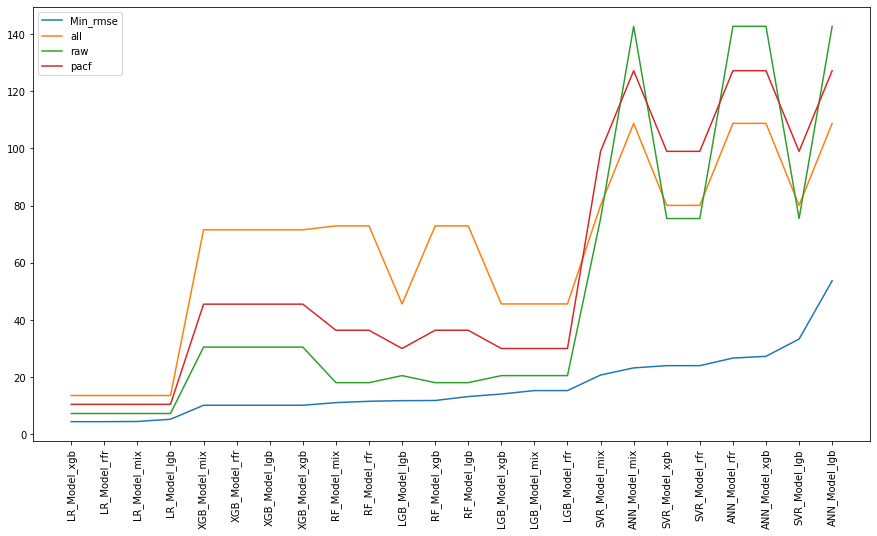

In [89]:
# plt.figure()
all_sort[['Min_rmse','all','raw','pacf']].plot(figsize=(15,8))
plt.xticks(range(0,len(all_sort.index),1),all_sort.index,rotation=90)
plt.savefig("./pic/RMSE/Diamond/Compare.png")
plt.show()

### 画图

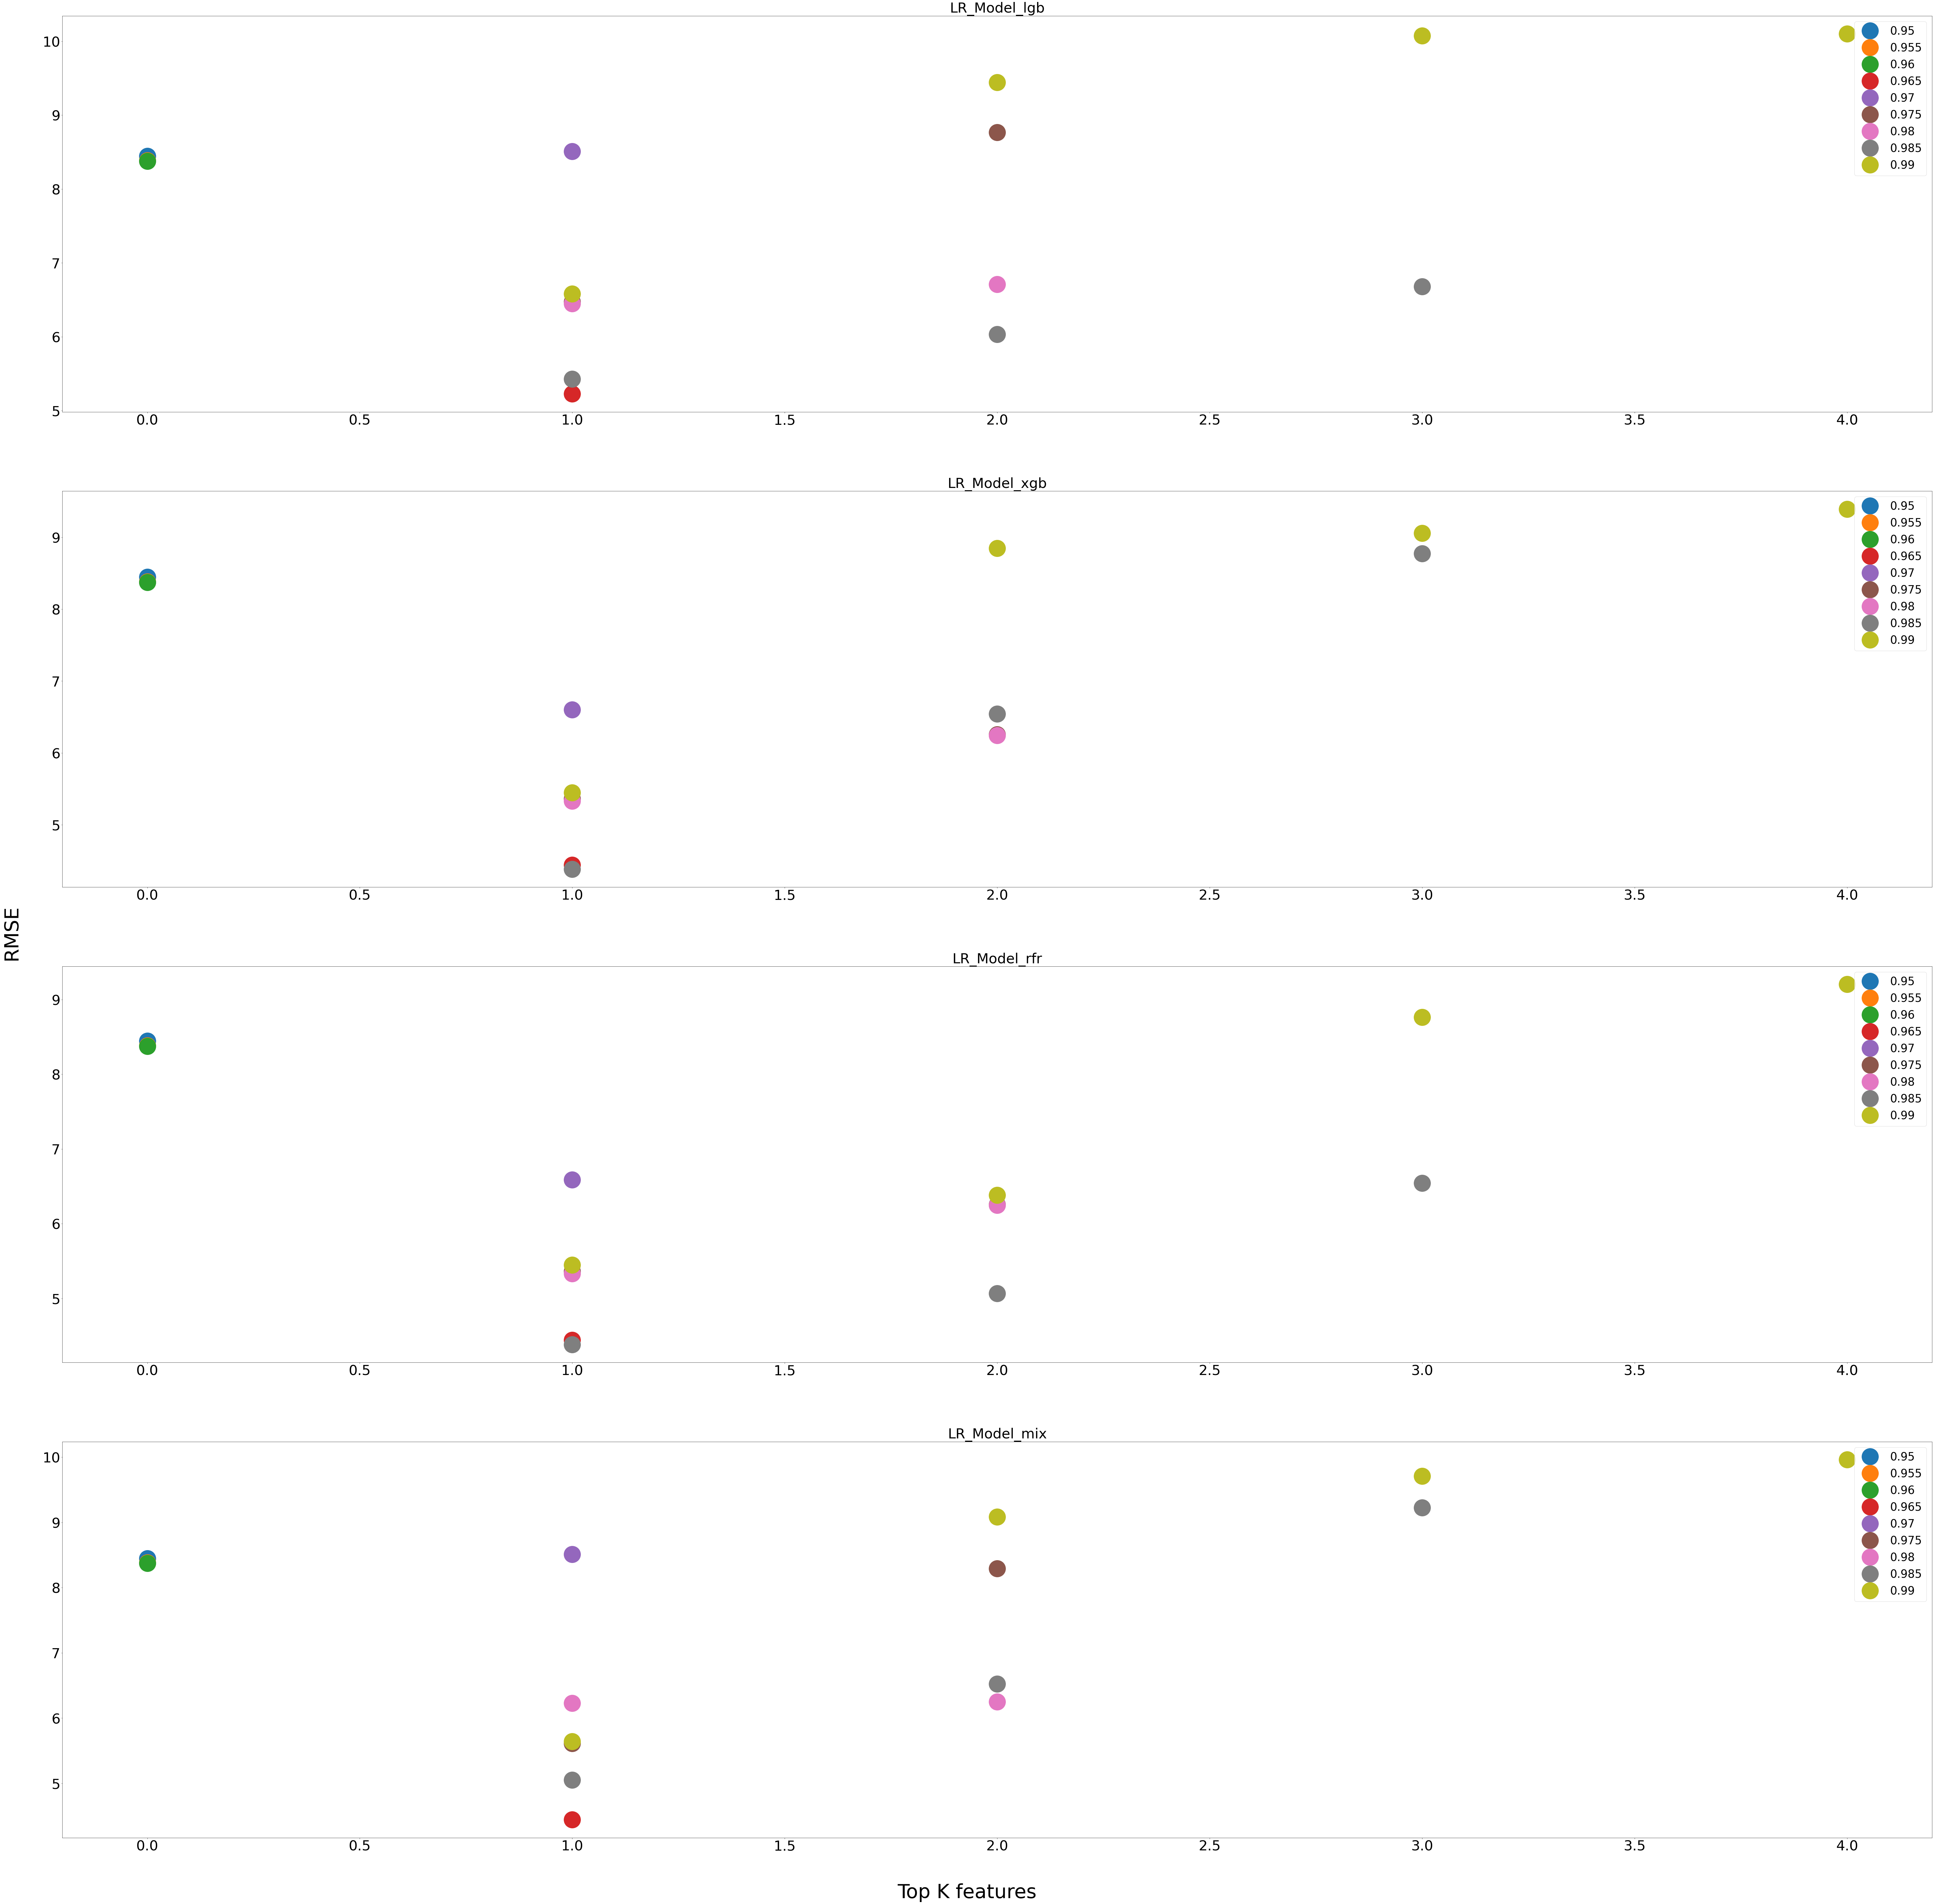

In [92]:
fig,ax = plt.subplots(len(linear_df),1,figsize=(120,120))
for order,k in zip(range(len(linear_df)),linear_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(linear_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
    ax[order].legend(linear_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Diamond/Linear.png')

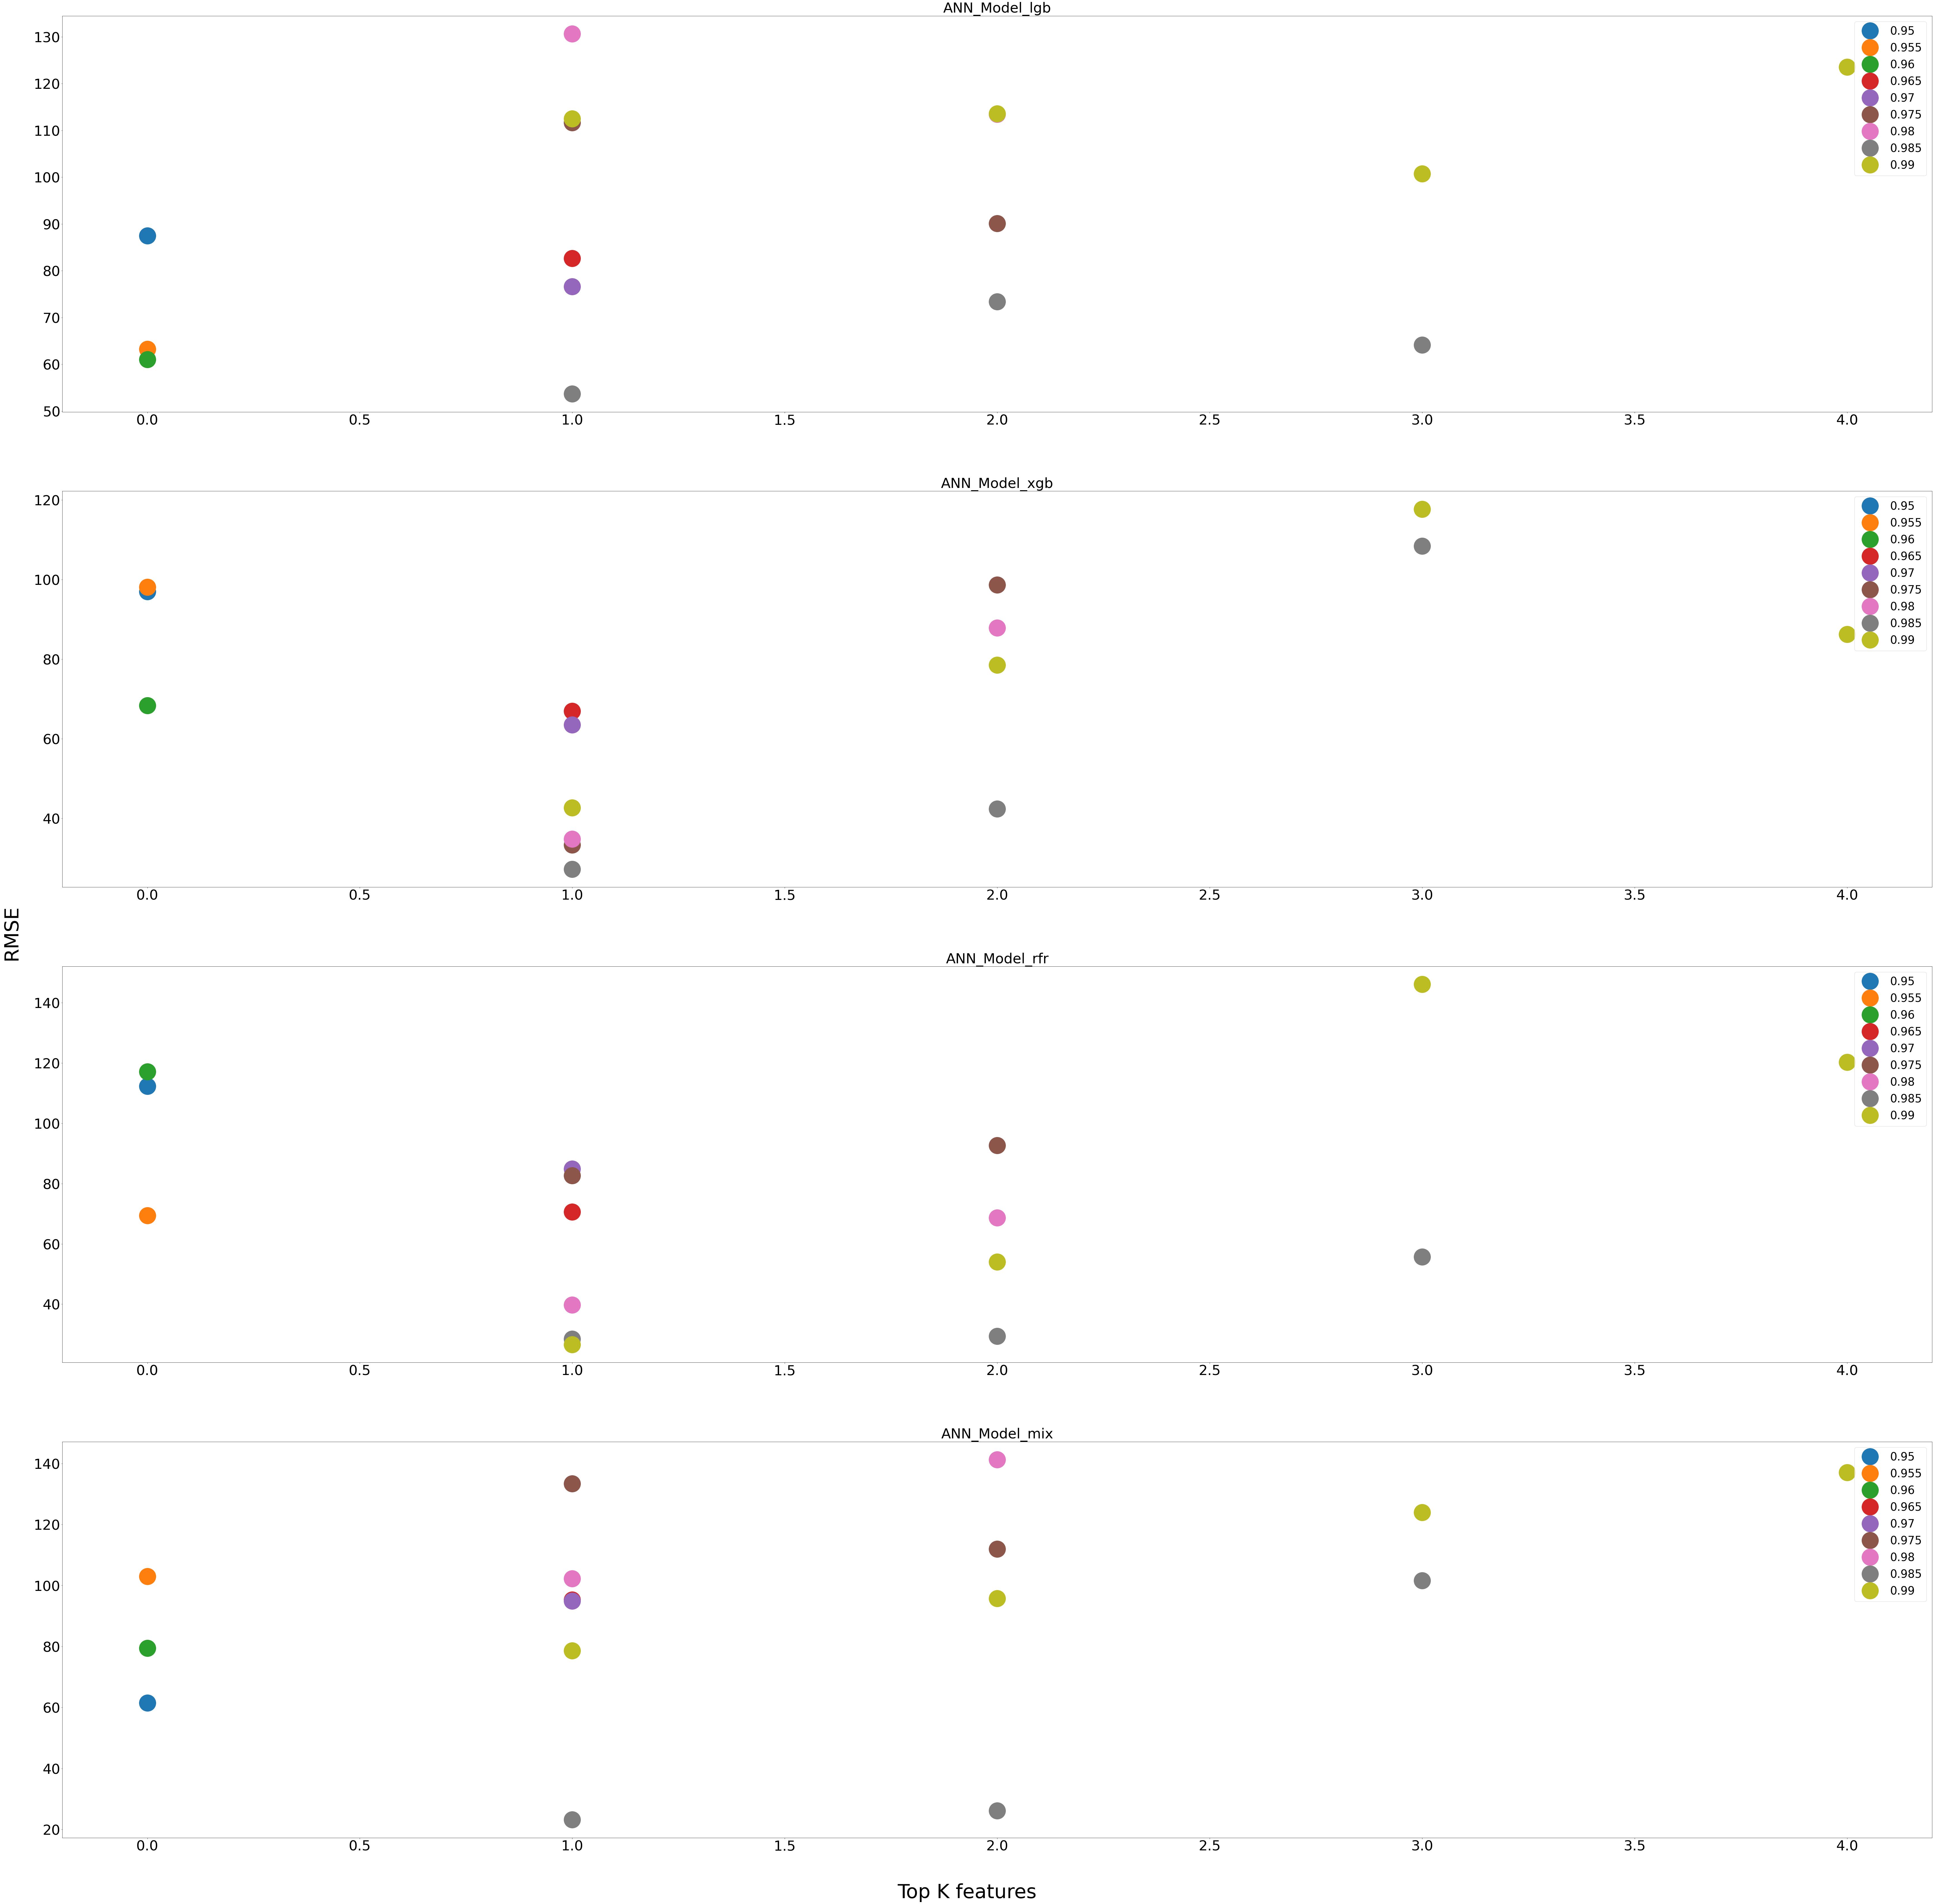

In [93]:
fig,ax = plt.subplots(len(ANN_df),1,figsize=(120,120))
for order,k in zip(range(len(ANN_df)),ANN_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(ANN_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
    ax[order].legend(ANN_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Diamond/ANN.png')

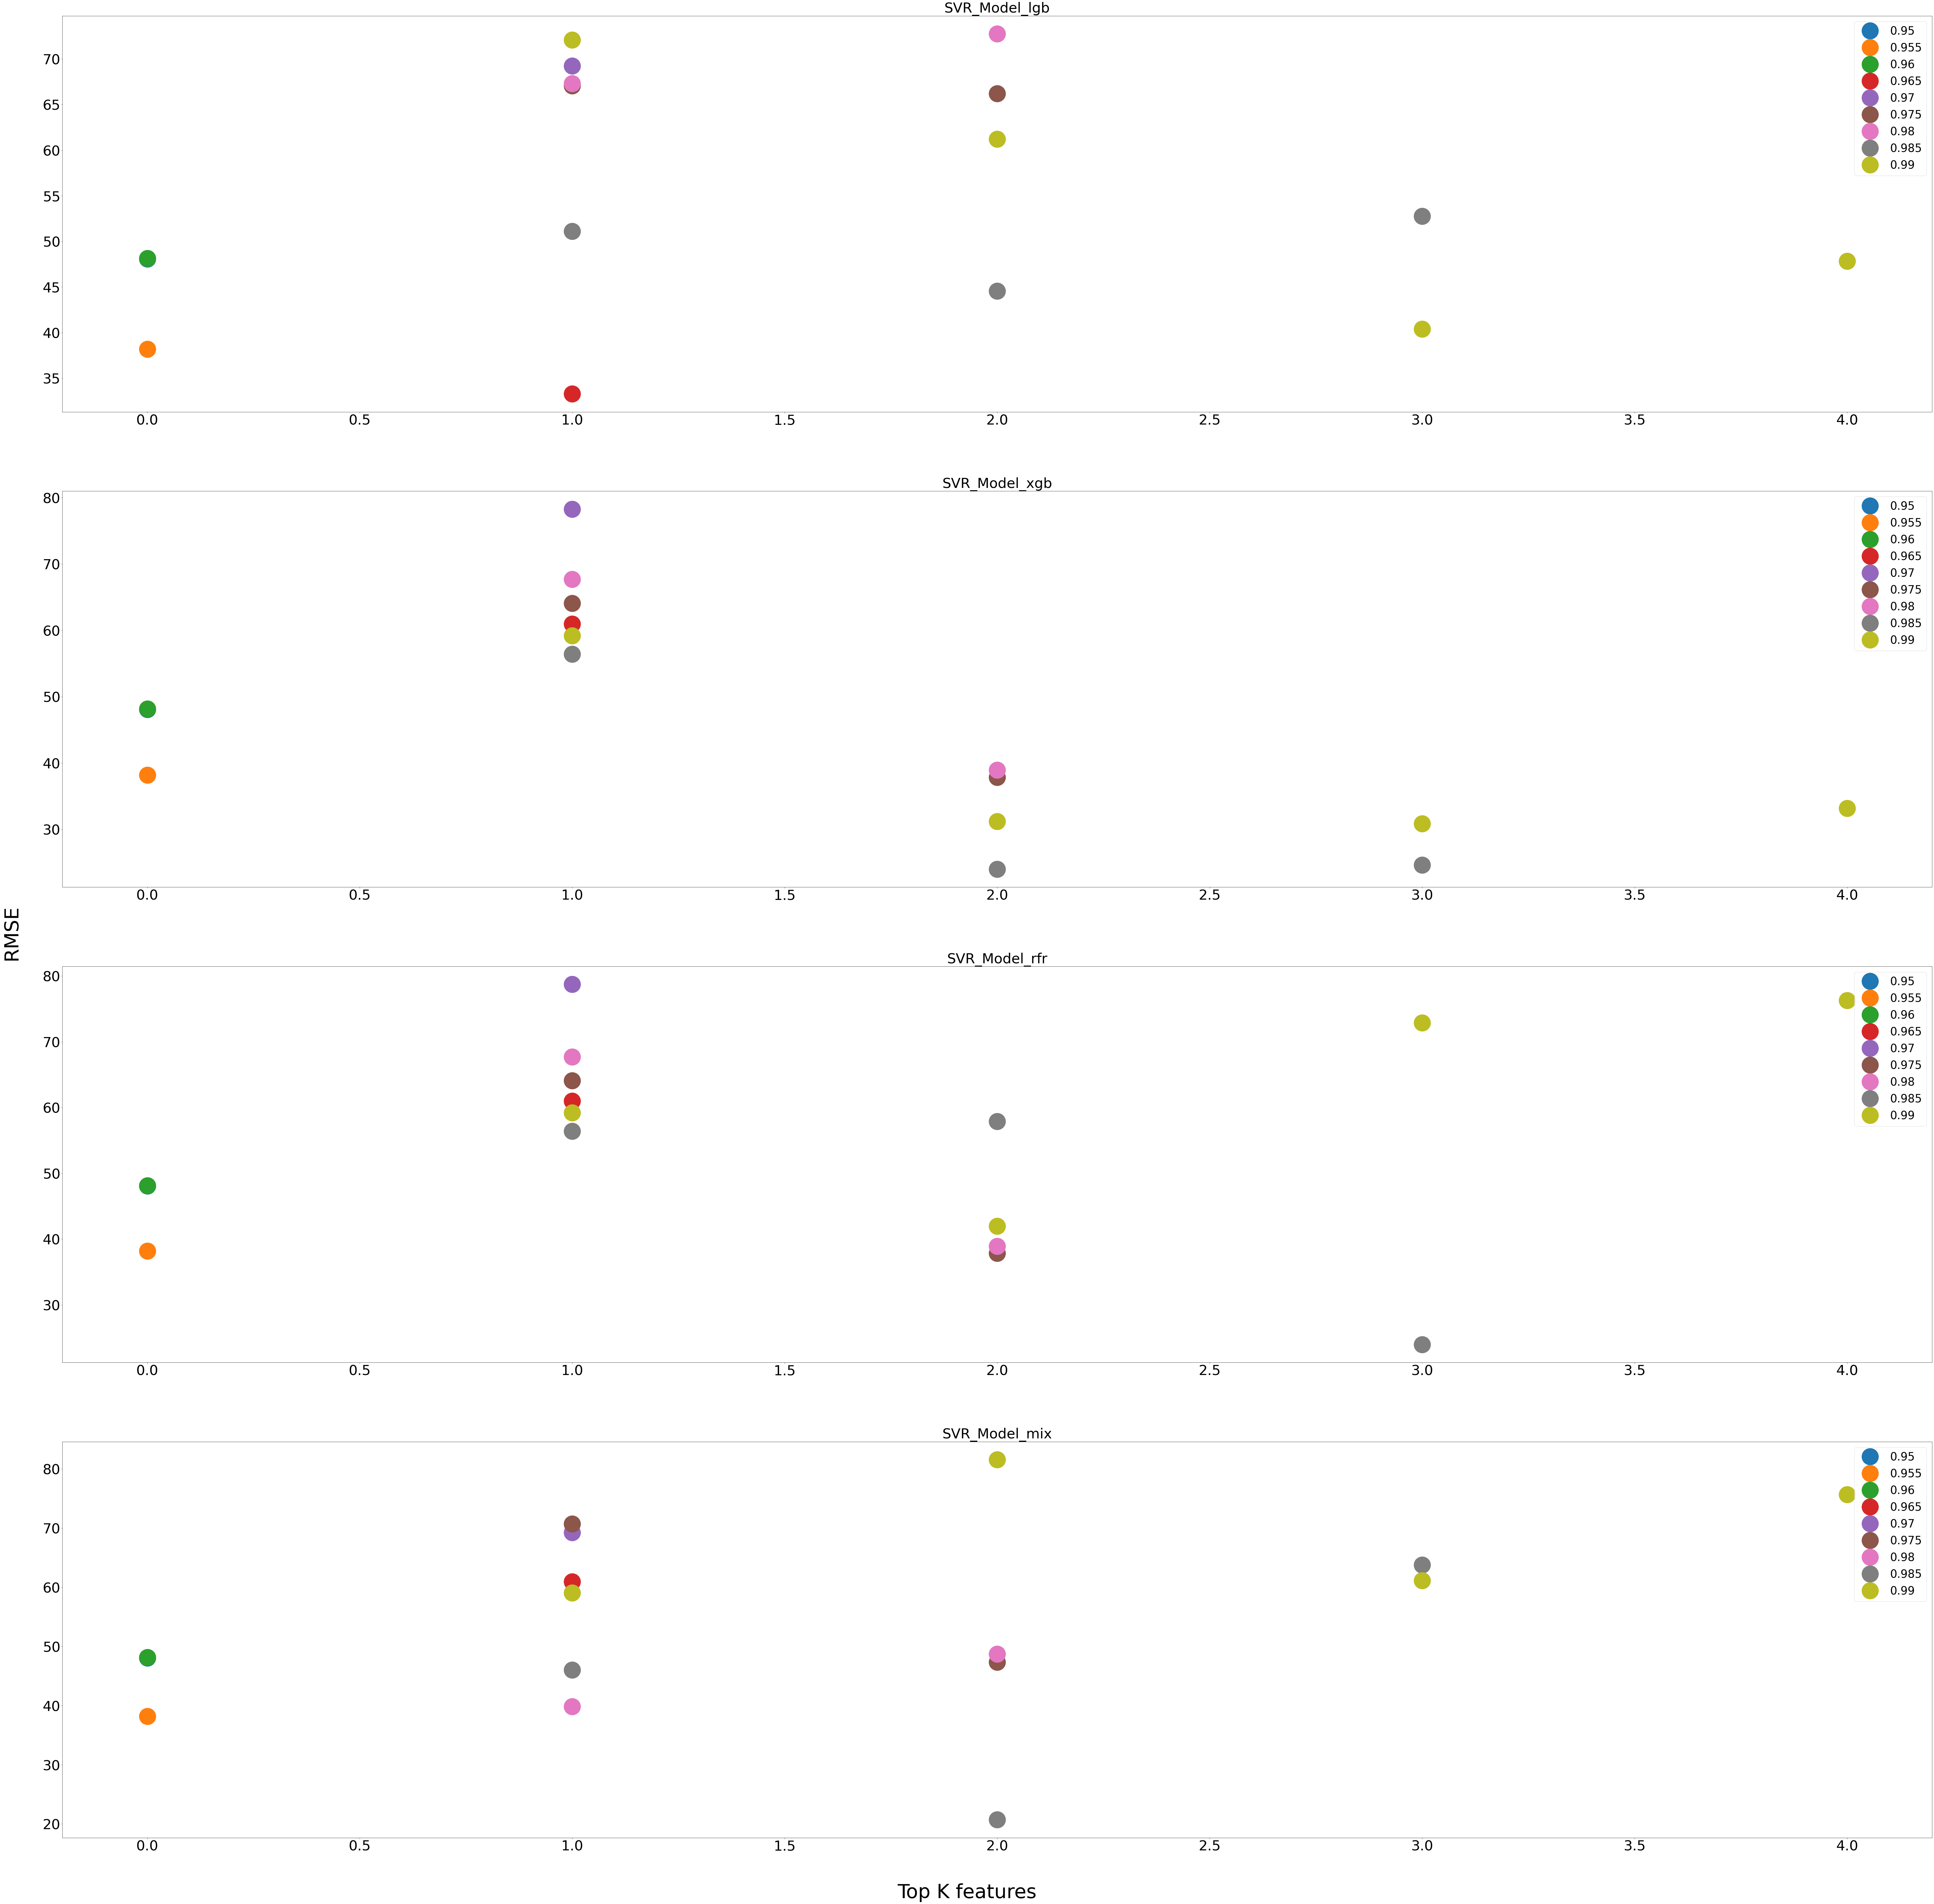

In [94]:
fig,ax = plt.subplots(len(SVR_df),1,figsize=(120,120))
for order,k in zip(range(len(SVR_df)),SVR_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(SVR_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
    ax[order].legend(SVR_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Diamond/SVR.png')

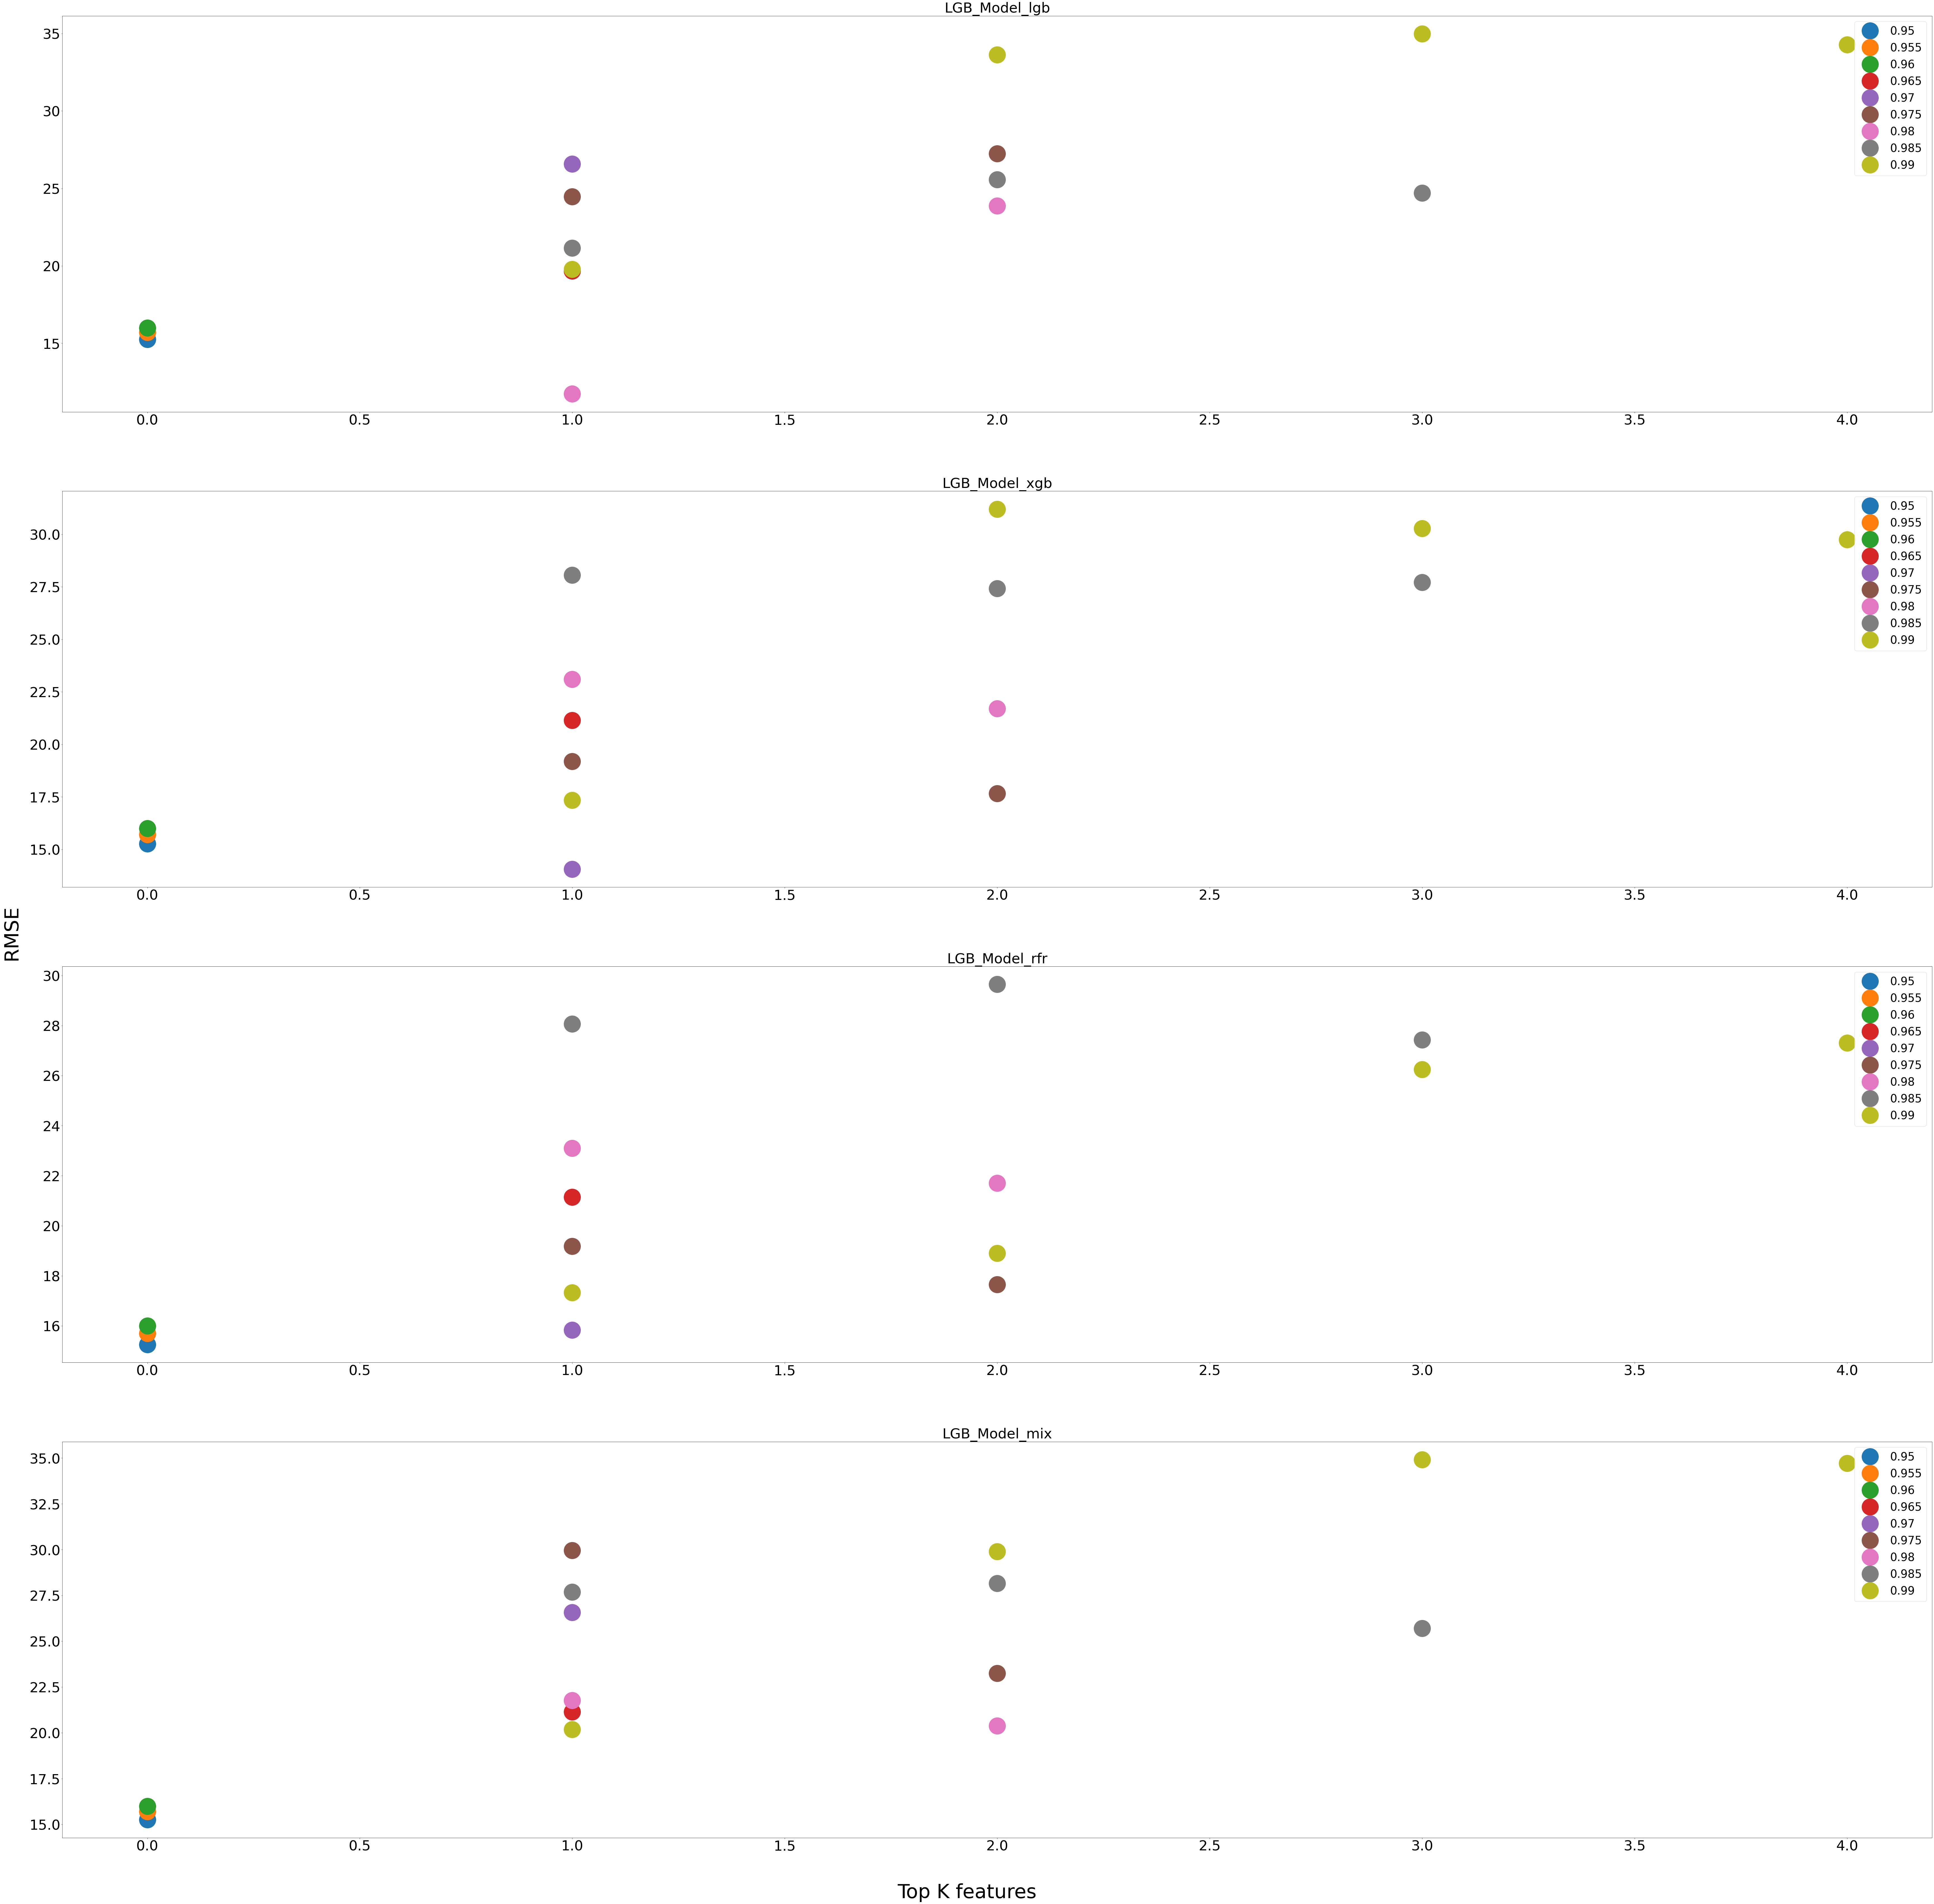

In [95]:
fig,ax = plt.subplots(len(LGB_df),1,figsize=(120,120))
for order,k in zip(range(len(LGB_df)),LGB_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(LGB_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
    ax[order].legend(LGB_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Diamond/LGB.png')

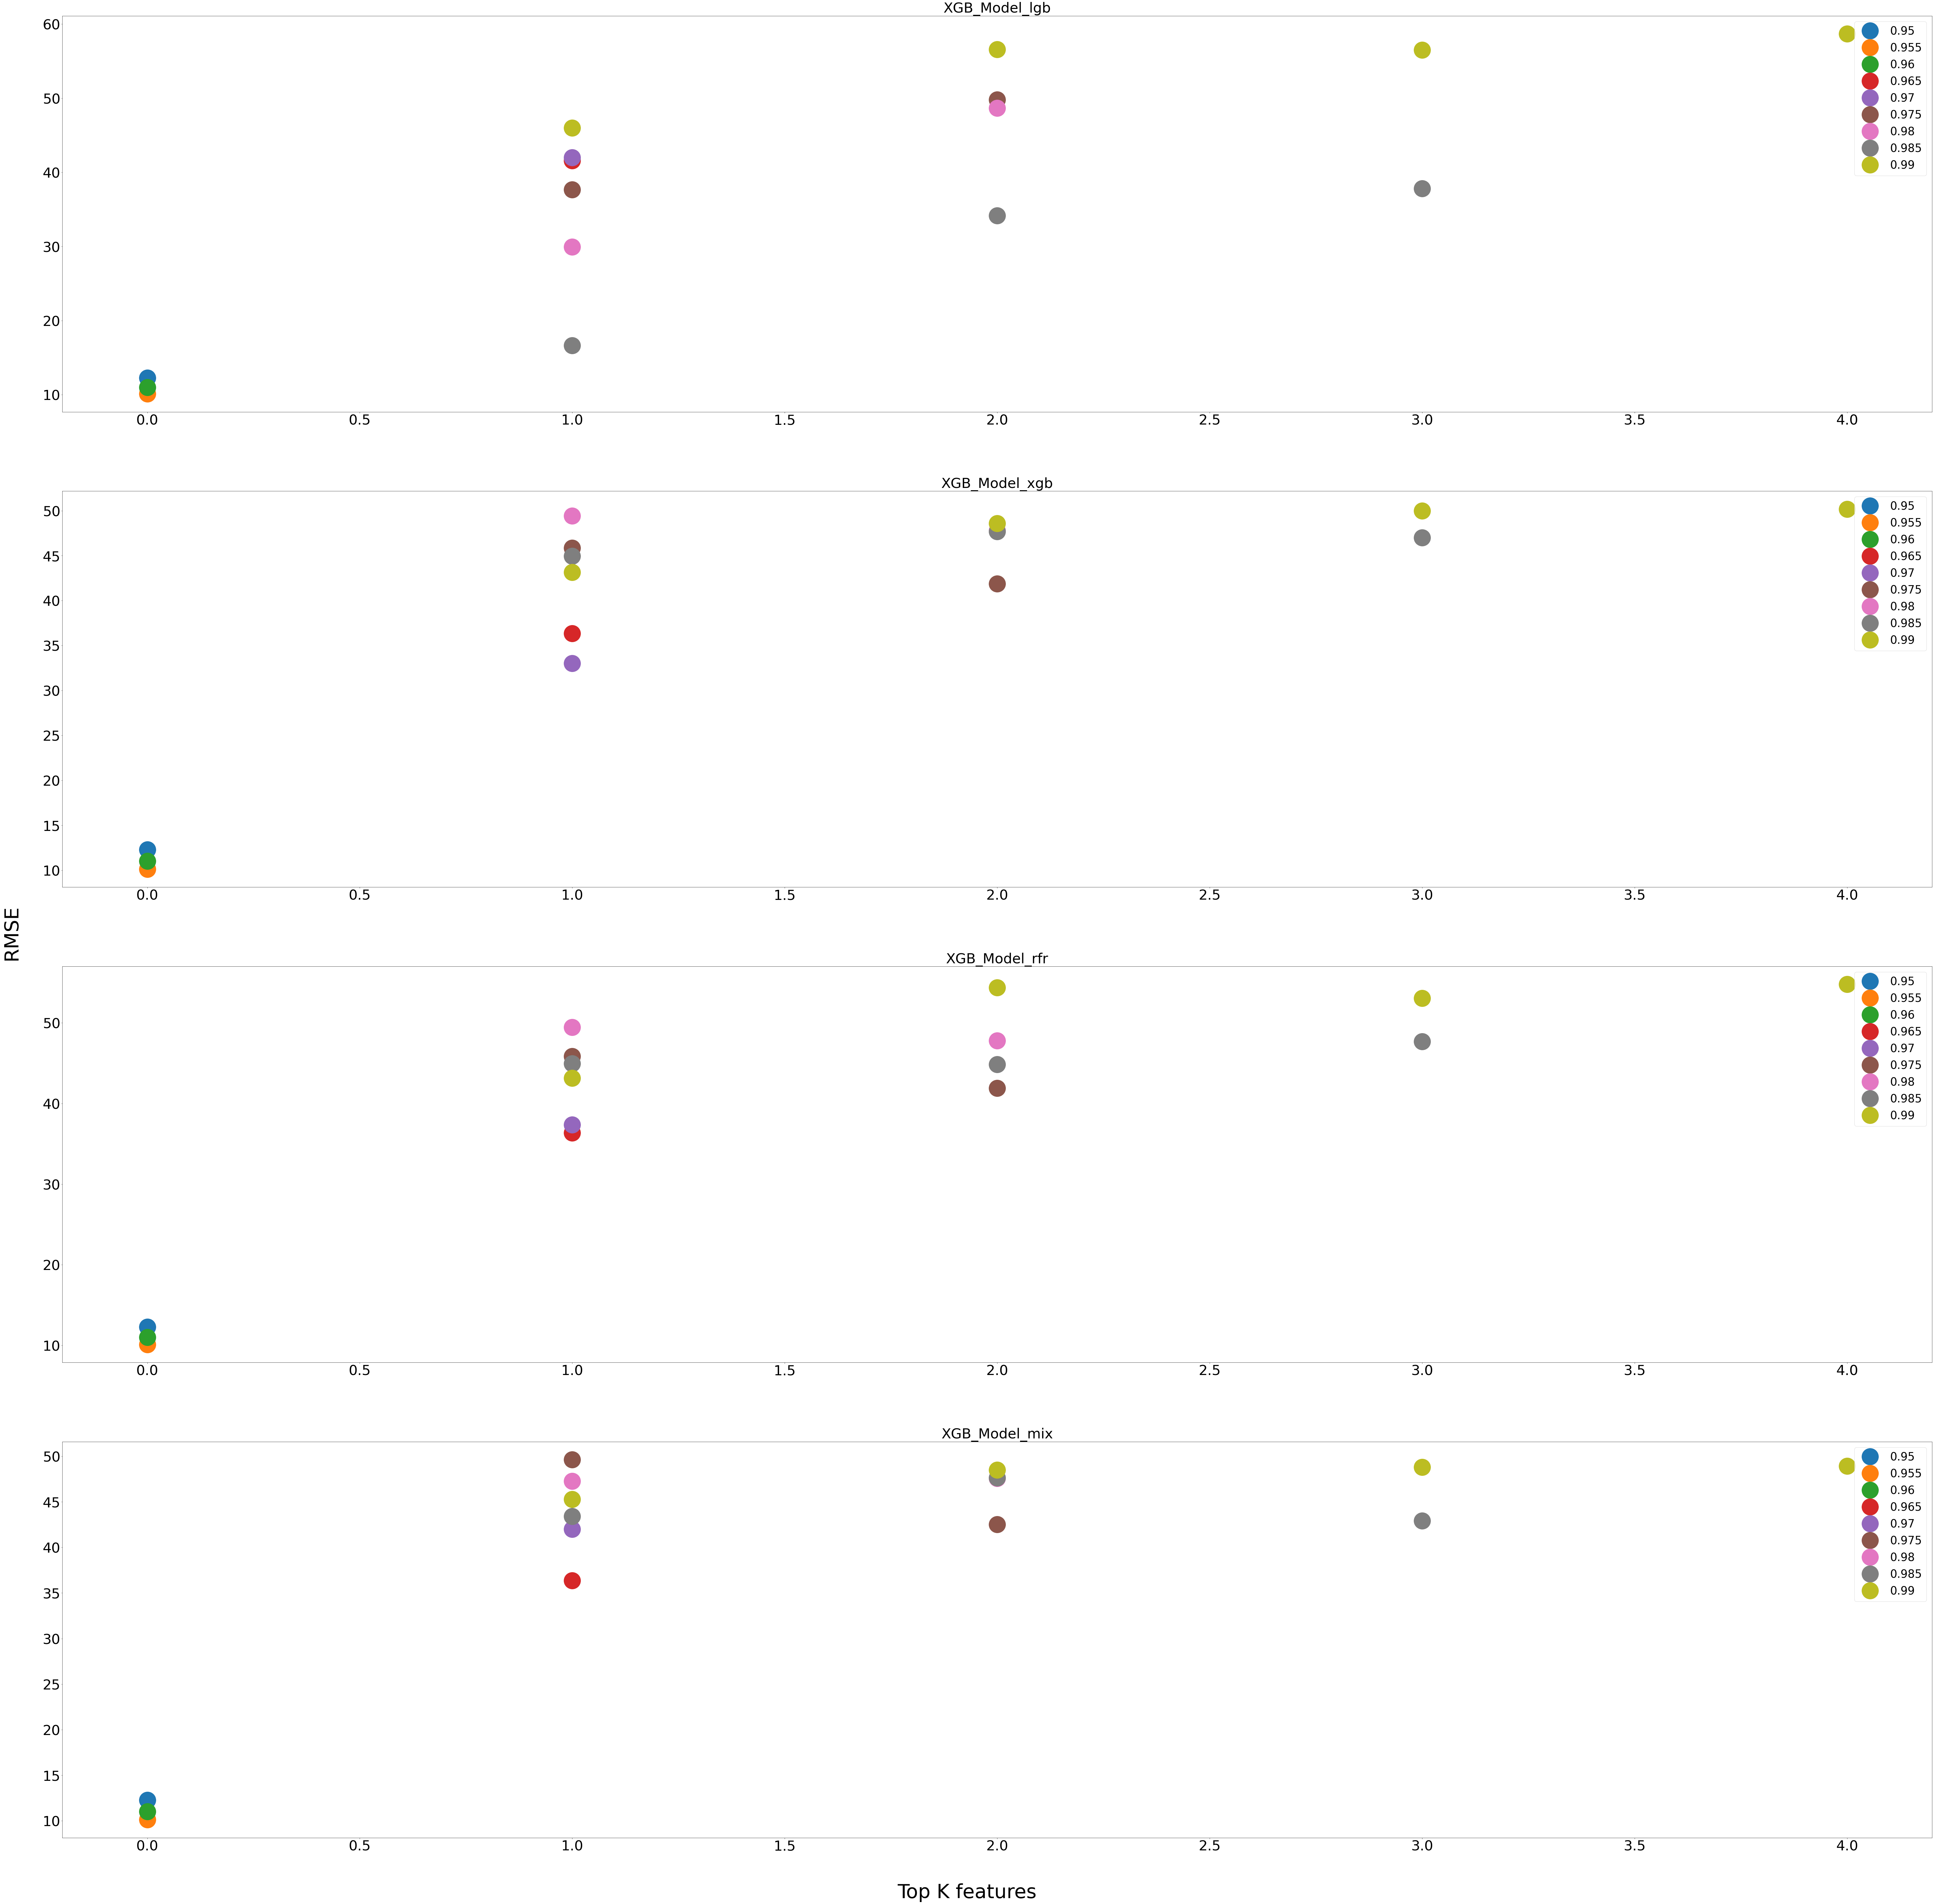

In [96]:
fig,ax = plt.subplots(len(XGB_df),1,figsize=(120,120))
for order,k in zip(range(len(XGB_df)),XGB_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(XGB_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
    ax[order].legend(XGB_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Diamond/XGB.png')

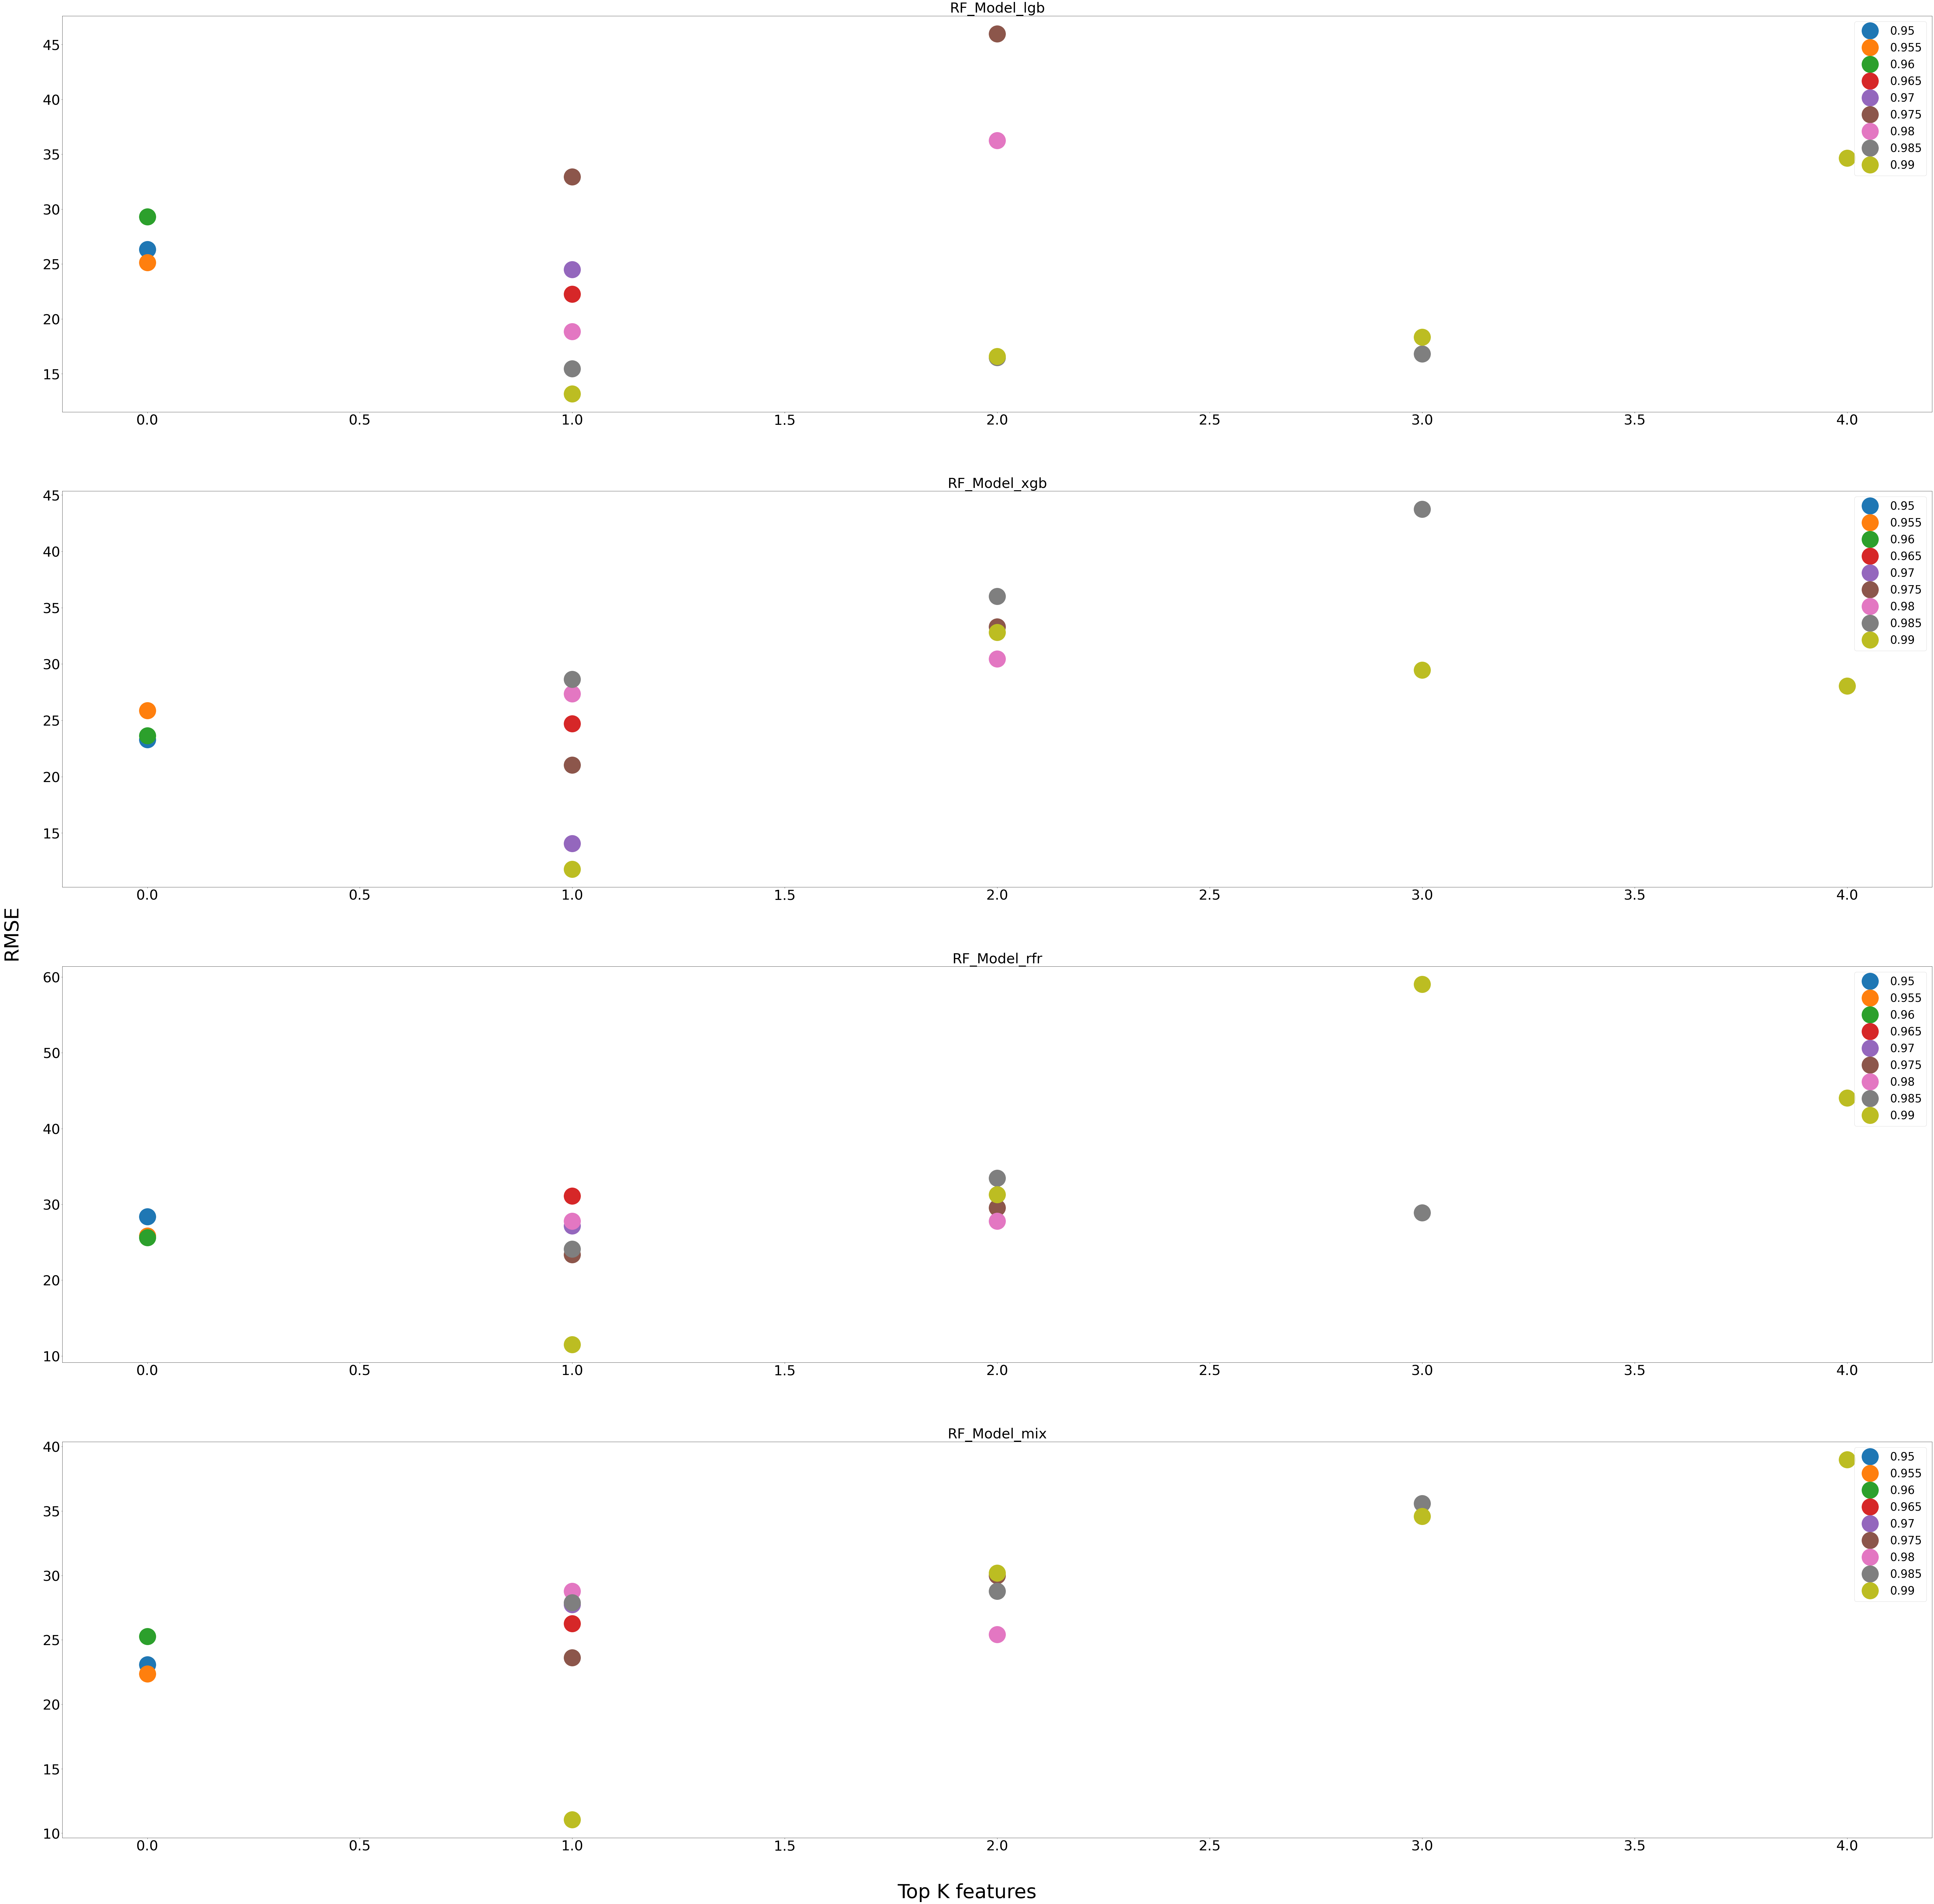

In [97]:
fig,ax = plt.subplots(len(RF_df),1,figsize=(120,120))
for order,k in zip(range(len(RF_df)),RF_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(RF_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
    ax[order].legend(RF_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Diamond/RF.png')

In [98]:
def LR_plot(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )

    reg_Linear =  LinearRegression()
    reg_Linear.fit(x_train,y_train.reshape(-1,))
    y_Linear = reg_Linear.predict(x_test)
    y_Linear_inverse =minmax_y_test.inverse_transform(y_Linear.reshape((-1,1)))
    
    y_df = pd.DataFrame({
        'Actual':y_Linear_inverse.reshape(-1,),
        'Predicted':y_test_inverse.reshape(-1,)
    },index=Y_test.index)
    print(r2_score(y_Linear_inverse.reshape(-1,),y_test_inverse.reshape(-1,)))
    plt.figure(figsize=(15,8))
    plt.xticks(range(0,len(y_df.index),10),rotation=45)
    plt.plot(y_df['Actual'],label='Actual')
    plt.plot(y_df['Predicted'],linestyle='dashdot',label='Predicted')
    plt.legend()
    plt.savefig("./pic/RMSE/Diamond/Final_prediction.png")
    return y_df

0.9995589670498408


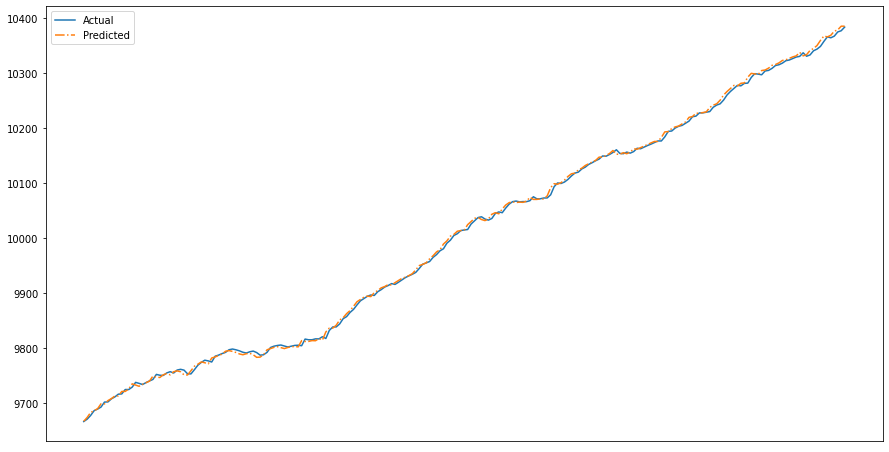

In [99]:
yy = LR_plot(X_train_lag[real_xgb[0.985][1]],Y_train_lag,X_test_lag[real_xgb[0.985][1]],Y_test_lag)